# Velocity change in soil -- Harper farm

Auto-correlation functions of DAS --> velocity changes,

Which reflects the measured soil mositure, temperature and tilling.

In [12]:
import os
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
import h5py

import sys
sys.path.append(".")
from das_util import read_decimate, get_tstamp
from das_util import next_power_of_2, calc_NFFT

sys.path.append("noisepy4das_repo/NoisePy4DAS-SeaDAS/src")
import DAS_module

sys.path.append("noisepy4das_repo/NoisePy4DAS-SeaDAS/DASstore")
from dasstore.zarr import Client

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 16})

import gc
import cv2
import math
import time
import numpy as np
import pandas as pd

import scipy.signal as sgn
from scipy.signal import butter
from scipy.signal import detrend
from scipy.signal import decimate
from scipy.signal import filtfilt
from scipy.signal import find_peaks
from scipy.signal import spectrogram
from scipy.interpolate import interp1d

from tqdm import tqdm
from obspy import UTCDateTime
from datetime import datetime
from datetime import timedelta
from functools import partial
from multiprocessing import Pool

### Functions for DVV and PDF denoising

In [2]:
def fk_filter_2cones(vsp, w1=0, w2=0, cone1=False, cone2=False):
    n1, n2 = vsp.shape
    nf = next_power_of_2(n1)
    nk = next_power_of_2(n2)

    nf2=int(nf/2)
    nk2=int(nk/2)
    
    fk2d = np.fft.fft2(vsp, s=(nf,nk))
    fk2d = np.fft.fftshift(fk2d, axes=(-2,-1))
    
    nw1 = int(np.ceil(w1*nk))
    nw2 = int(np.ceil(w2*nf))

    mask1=np.ones((nf,nk), dtype=np.float64)
    mask2=np.ones((nf,nk), dtype=np.float64)

    if cone1:
        for j in np.arange(nk2-nw1, nk2+1):
            th1 = int((j-nk2+nw1) * nf2/nw1)

            mask1[:th1, j] = 0
            mask1[nf-th1:, j] = 0
            mask1[:th1, nk-j] = 0
            mask1[nf-th1:, nk-j] = 0

    if cone2:
        for j in np.arange(0, nk2):
            th2 = int(nf2 - (nw2/nk2)*(nk2-j))
            mask2[th2:nf-th2+1, j] = 0
            if j != 0:
                mask2[th2:nf-th2+1, nk-j] = 0


    mask = mask2*mask1
    
    filtered_2d = fk2d * mask
    tmp = np.fft.ifftshift(filtered_2d)
    output = np.fft.ifft2(tmp, s=(nk,nf), axes=(-1, -2))
    
    return output[:n1,:n2], filtered_2d, fk2d

In [3]:
def stretch(wave1, wave2, time, maxshift=0, max_ratio=2):

    interp_f = interp1d(time, wave2, bounds_error=False, fill_value=0.)
    n1 = np.sum(np.square(wave1))
    dt = time[1] - time[0]
    cc = 0
    relative_ratio = 1
    npts = len(time)

    for ratio in np.arange(1/max_ratio, max_ratio, 0.01):
        dt_new = dt / ratio
        time_new = np.arange(time[0], time[-1], dt_new)
        wave_new = interp_f(time_new)
        
        n2 = np.sum(np.square(wave_new))
        corr = sgn.correlate(wave1, wave_new) / np.sqrt(n1 * n2)

        l_maxshift = min(len(wave_new), maxshift)
        r_maxshift = min(len(wave1), maxshift)

        st_pt = len(wave_new) - l_maxshift
        en_pt = len(wave_new) + r_maxshift+1

        cc_best = np.nanmax(corr[st_pt: en_pt])

        if cc < cc_best:
            cc = cc_best
            relative_ratio = ratio

    dt_new = dt / relative_ratio
    time_new = np.arange(time[0], time[-1], dt_new)
    wave_new = interp_f(time_new)
    
    
    return wave_new, np.arange(len(wave_new))*dt, relative_ratio, cc

In [9]:
def stretch_distribution(wave1, wave2, time, maxshift=0, max_ratio=2):

    stretch_range = np.arange(1/max_ratio, max_ratio, 0.01)
    
    interp_f = interp1d(time, wave2, bounds_error=False, fill_value=0.)
    n1 = np.sum(np.square(wave1))
    dt = time[1] - time[0]
    cc = np.zeros(len(stretch_range), dtype = np.float32)
    npts = len(time)

    for i, ratio in enumerate(stretch_range):
        dt_new = dt / ratio
        time_new = np.arange(time[0], time[-1], dt_new)
        wave_new = interp_f(time_new)
        
        n2 = np.sum(np.square(wave_new))
        corr = sgn.correlate(wave1, wave_new) / np.sqrt(n1 * n2)

        l_maxshift = min(len(wave_new), maxshift)
        r_maxshift = min(len(wave1), maxshift)

        st_pt = len(wave_new) - l_maxshift
        en_pt = len(wave_new) + r_maxshift+1

        cc[i] = np.nanmax(corr[st_pt: en_pt])
    
    return stretch_range, cc

# Data --DAS PSD

51 channels

2408 time segments

129 frequency points

In [4]:
# with h5py.File('/fd1/QibinShi_data/England_farm/psd_all.hdf5', 'w') as f:
#     f.create_dataset("psd_all_time", data=PSD_all_time)
#     f.create_dataset("frequency", data=freq)
#     f.create_dataset("daslist", data=file_list.astype('S'), dtype='S100')

with h5py.File('/fd1/QibinShi_data/England_farm/psd_all.hdf5', 'r') as f:
    file_list = f['daslist'][:].astype('U')
    PSD_all_time = f['psd_all_time'][:]
    freq = f['frequency'][:]
    
acqu_time = np.array([get_tstamp(i) for i in file_list])
start_file = np.arange(0, len(acqu_time), 5)
time_stamps = acqu_time[start_file]

## Mean PSD over channels
ave_psd=np.mean(np.sum(PSD_all_time[0:44, :, 52:90], axis=-1) * (freq[1]-freq[0]), axis=0)

## Index on the hour
hourly_index = [67,127,187,247,299,359,419,466,526,586,646,706,766,826,886,946,1003,1063,1123,
         1183,1243,1302,1362,1422,1482,1542,1599,1659,1719,1779,1839,1899,1959,2019,
         2078,2138,2198,2258,2318]

## smoothing over 1 hr window
hr_psd=[]
for ind in hourly_index:
    st_ind = int(ind - 60)
    ed_ind = st_ind + 60
    hr_psd.append(np.sum(ave_psd[st_ind:ed_ind]))

Ind6hrs = [7, 359, 706, 1063, 1422, 1779, 2138]
for i in Ind6hrs:
    print(acqu_time[i])

2023-03-17T18:00:00.000000Z
2023-03-18T00:00:00.000000Z
2023-03-18T06:00:00.000000Z
2023-03-18T12:00:00.000000Z
2023-03-18T18:00:00.000000Z
2023-03-19T00:00:00.000000Z
2023-03-19T06:00:00.000000Z


# Data -- Soil measurements

In [5]:
csv_file = pd.read_csv('NewportSalop_merged.csv', low_memory=False)
## Index for soil measurements
j = 32
# print(csv_file['Time'][j:j+40])

humidity=csv_file['Humidity'][j+1:j+40].to_numpy()
soil_temp_10=csv_file[' 10cm Soil Temperature'][j+1:j+40].to_numpy()
soil_temp_30=csv_file['30cm Soil Temperature'][j+1:j+40].to_numpy()
soil_temp_100=csv_file['100cm Soil Temperature'][j+1:j+40].to_numpy()
rainfall=csv_file[' Rainfall Total since 0900'][j:j+40].to_numpy()
rain_diff=np.diff(rainfall)

In [1]:
csv_file

NameError: name 'csv_file' is not defined

# Compare PSD with rainfall

Text(2138, 0.5, '6 am')

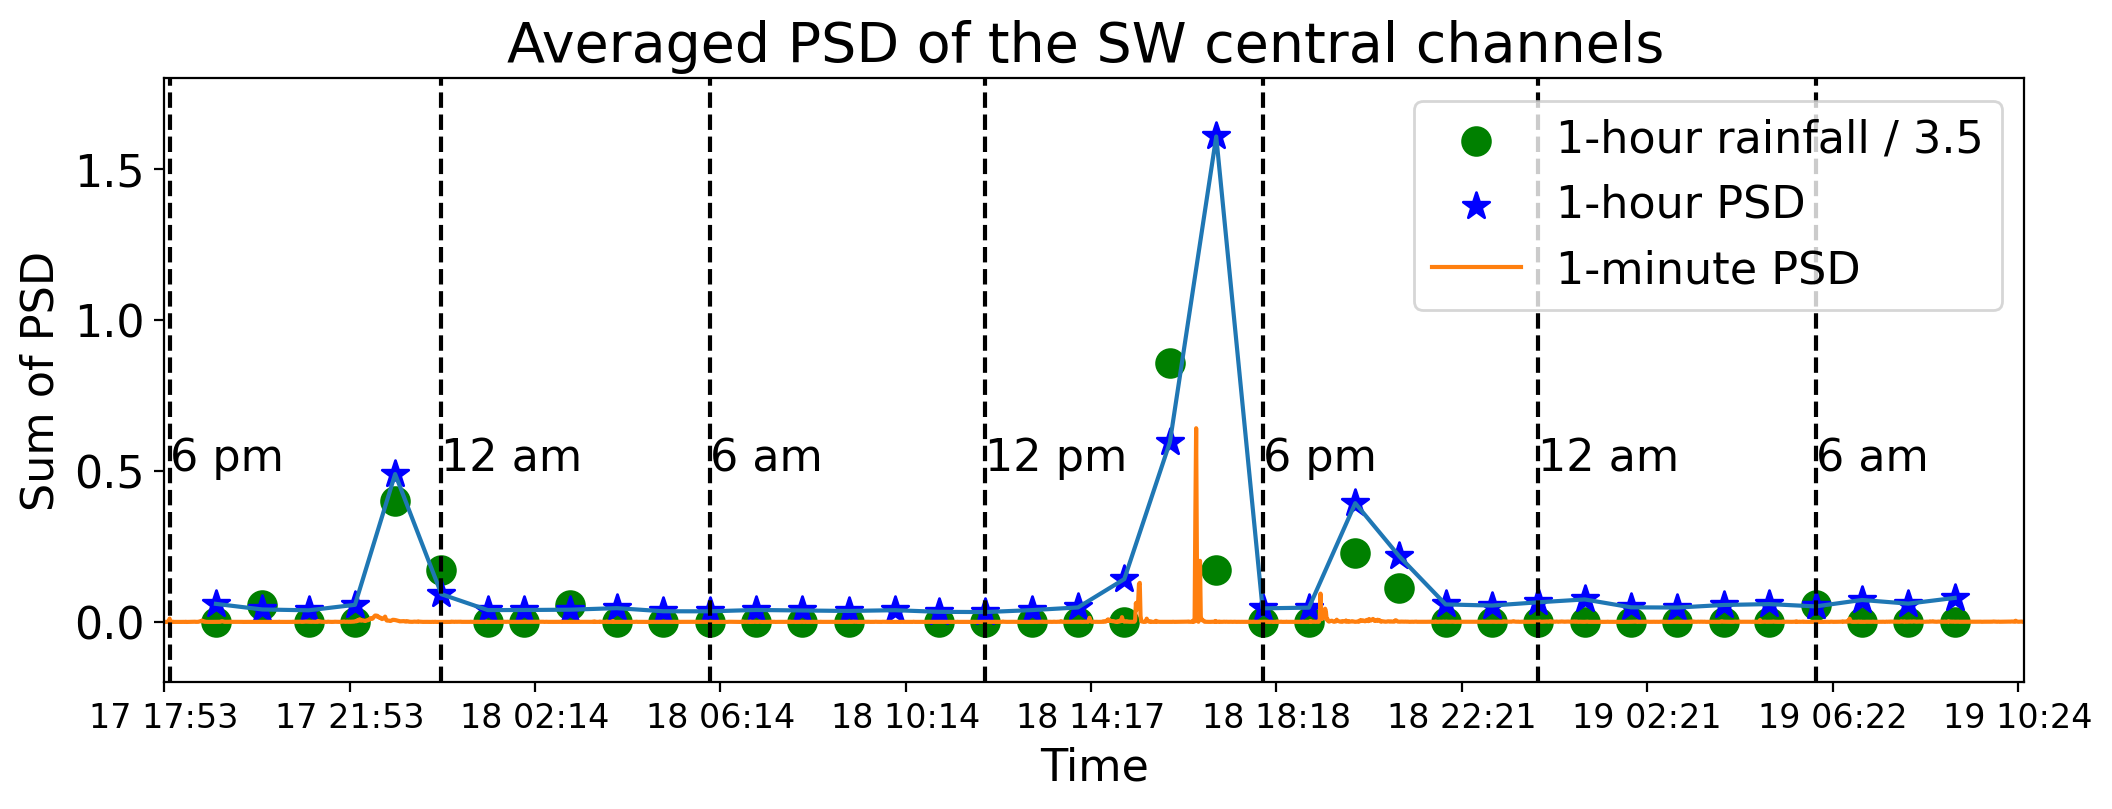

In [6]:
xax=np.arange(0, ave_psd.shape[-1], 240)
tax=acqu_time[:ave_psd.shape[-1]:240]
hrax=[dt.strftime('%d %H:%M') for dt in tax]
plt.figure(figsize = (12, 4), dpi = 200)   
plt.scatter(hourly_index, rain_diff/3.5, label='1-hour rainfall / 3.5', color='g', marker='o', s=100)
plt.scatter(hourly_index, np.array(hr_psd), label='1-hour PSD', color='b', marker='*', s=100)
plt.plot(hourly_index, np.array(hr_psd))
plt.plot(np.arange(ave_psd.shape[-1]), ave_psd, label='1-minute PSD')
plt.xticks(xax, hrax, fontsize = 12)
plt.xlabel("Time", fontsize = 16)
plt.ylabel("Sum of PSD", fontsize = 16)
plt.title('Averaged PSD of the SW central channels ', fontsize = 20)  
plt.ylim(-0.2, 1.8)
plt.xlim(0, ave_psd.shape[-1])
plt.legend()

for it in Ind6hrs:
    plt.axvline(x = it, color = 'k', linestyle='--')
plt.text(Ind6hrs[0], 0.5, '6 pm', color='k')
plt.text(Ind6hrs[1], 0.5, '12 am', color='k')
plt.text(Ind6hrs[2], 0.5, '6 am', color='k')
plt.text(Ind6hrs[3], 0.5, '12 pm', color='k')
plt.text(Ind6hrs[4], 0.5, '6 pm', color='k')
plt.text(Ind6hrs[5], 0.5, '12 am', color='k')
plt.text(Ind6hrs[6], 0.5, '6 am', color='k')

# Data --ACF 

### Stretch using mean ACF, and stack for a reference ACF

In [7]:
freqmin=25
freqmax=50
samp_freq = 500
dchan = 3.19
win_st = int(0.012*samp_freq)

with h5py.File('/fd1/QibinShi_data/England_farm/autocorr_'+str(freqmin)+'_'+str(freqmax)+'Hz.hdf5', 'r') as f:
    corr_all_time = f['autocorr'][:, :, 2500:3000, 0]
    
x=np.arange(corr_all_time.shape[1])
y=np.arange(corr_all_time.shape[2])
xax=np.arange(0, x.shape[-1], 48)
tax=acqu_time[:2410:240]
stretch_range = np.arange(1/2, 2, 0.01)

time = y[win_st:] / samp_freq
stack_stretch=np.zeros((51, len(time)), dtype = np.float32)

for iloc in range(51):
    data_plot=corr_all_time[iloc].T
    trunc_acf = data_plot[win_st:, :]
    trunc_stk = np.mean(trunc_acf, axis=1)
    
    count = 0
#     plt.figure(figsize = (10, 3), dpi = 200)
    for i in x[::5]:
        tmp=np.zeros_like(time)
        stretched, time_new, ratio, cc = stretch(trunc_stk, trunc_acf[:,i], time, max_ratio=2)
        if cc > 0.5:  # stack
            length=min(len(stretched), len(time))
            tmp[:length]=stretched[:length]
            stack_stretch[iloc, :] += tmp
#             plt.plot(time, tmp)
            count +=1
        else:continue
#     plt.plot(time, stack_stretch[iloc, :]/count, c='k', lw=9, alpha=0.5, label='mean of all')
#     plt.title('channel '+ str(iloc+44)); plt.legend(); plt.xlabel('lag time (s)')

### Two examples: dvv distribution 

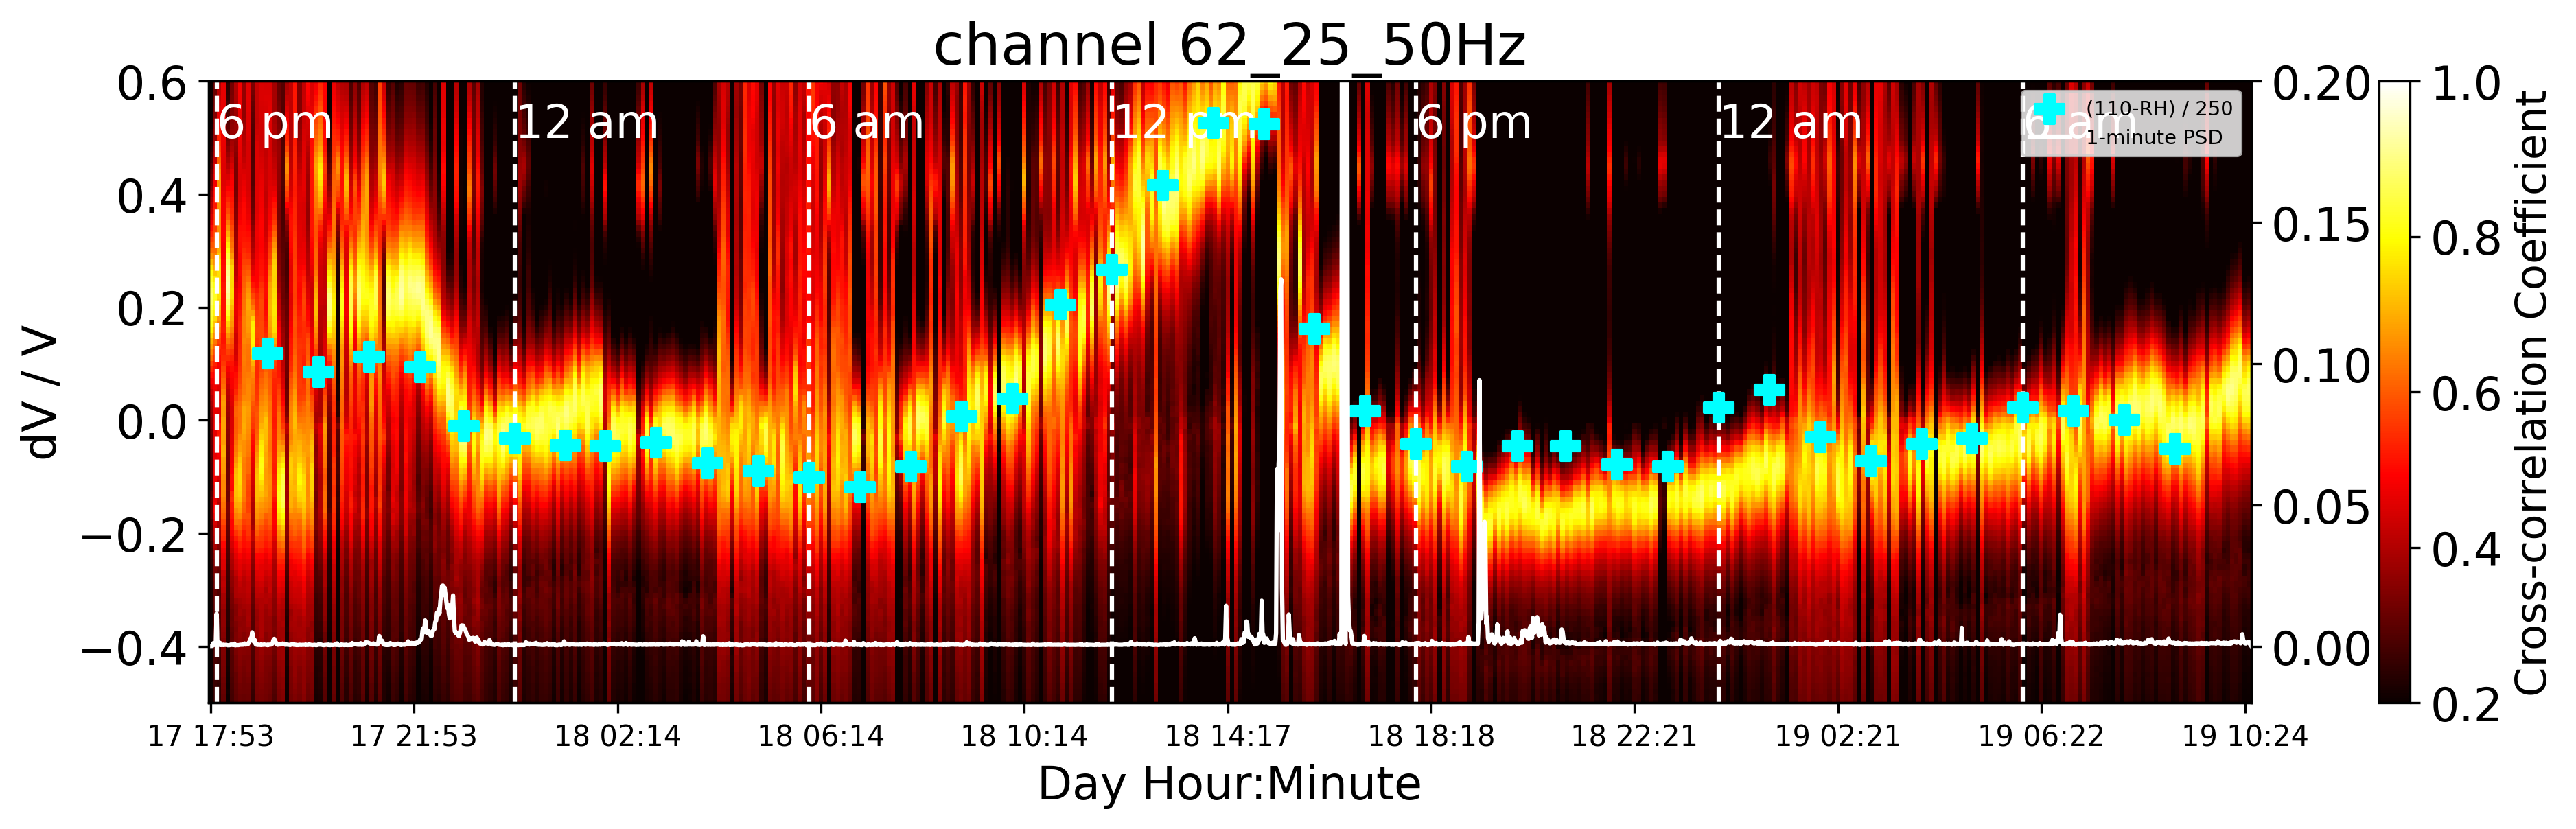

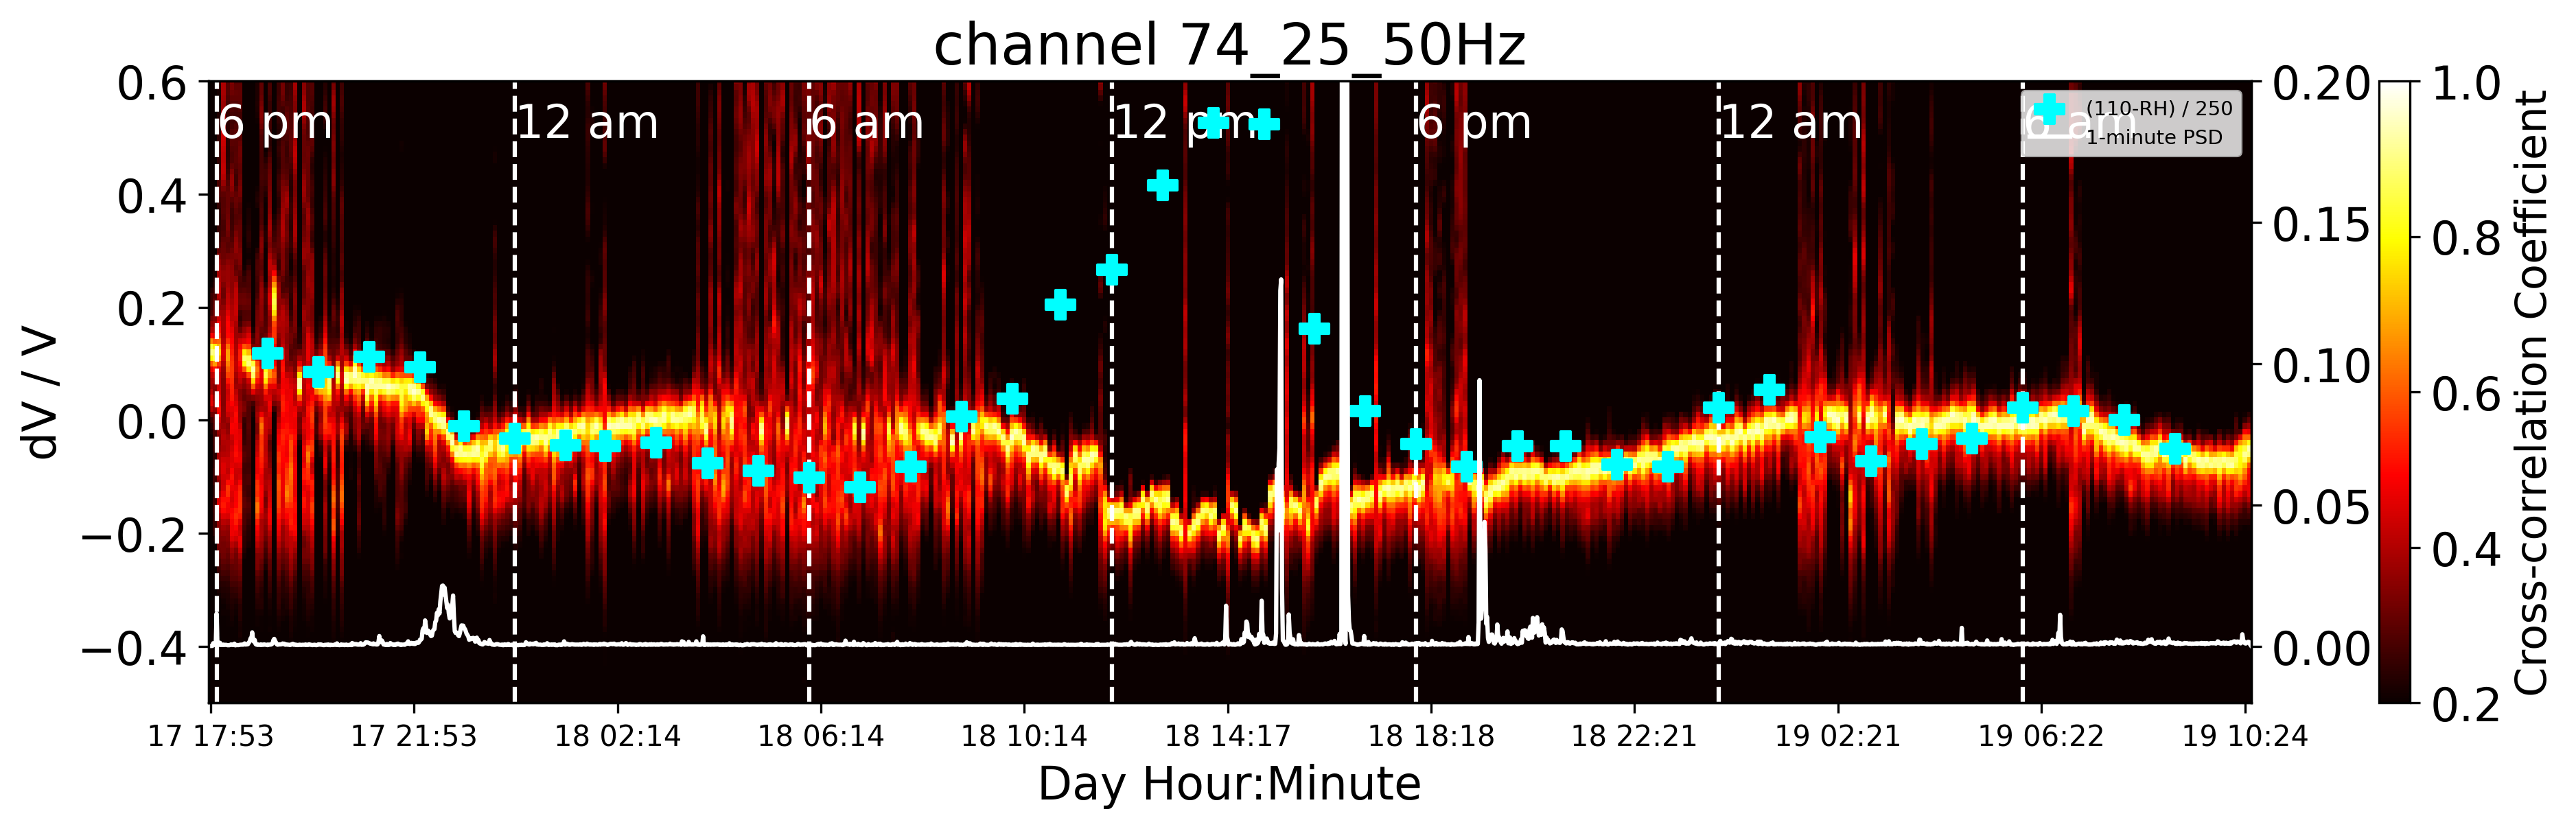

In [9]:
all_cc = np.zeros((51, len(stretch_range), len(x)), dtype = np.float32)

for iloc in [18,30]:
    data_plot=corr_all_time[iloc].T
    trunc_acf = data_plot[win_st:, :]
    trunc_stk = stack_stretch[iloc, :]/count
    strecthed_acfs = np.zeros_like(trunc_acf)
    for i in x:
        ratios, ccs = stretch_distribution(trunc_stk, trunc_acf[:,i], time, max_ratio=2)
        all_cc[iloc, :, i] = ccs  
    plt.figure(figsize = (16, 4), dpi = 300)
    plt.pcolormesh(x, stretch_range-1, all_cc[iloc], shading='auto', vmin=0.2, vmax=1, cmap = 'hot')
    plt.xticks(xax, hrax, fontsize = 10)
    plt.xlabel("Day Hour:Minute", fontsize = 16)
    plt.ylabel("dV / V", fontsize = 16)
    plt.ylim(-0.5, 0.6)
    plt.title('channel '+ str(iloc+44)+ '_' + str(freqmin)+'_'+str(freqmax)+'Hz', fontsize = 20)
    bar = plt.colorbar()
    bar.set_label('Cross-correlation Coefficient', fontsize = 15)
    for it in Ind6hrs:
        plt.axvline(x = it/5, color = 'w', linestyle='--')
    plt.text(Ind6hrs[0]/5, 0.5, '6 pm', color='w')
    plt.text(Ind6hrs[1]/5, 0.5, '12 am', color='w')
    plt.text(Ind6hrs[2]/5, 0.5, '6 am', color='w')
    plt.text(Ind6hrs[3]/5, 0.5, '12 pm', color='w')
    plt.text(Ind6hrs[4]/5, 0.5, '6 pm', color='w')
    plt.text(Ind6hrs[5]/5, 0.5, '12 am', color='w')
    plt.text(Ind6hrs[6]/5, 0.5, '6 am', color='w')

    
    axcopy = plt.twinx()
#     axcopy.scatter(np.array(hourly_index)/5, soil_temp_10-7.5, label='T_10cm', color='w', marker='^')
#     axcopy.scatter(np.array(hourly_index)/5, (soil_temp_30-7.5), label='T_30cm', color='w', marker='s')
#     axcopy.scatter(np.array(hourly_index)/5, (soil_temp_100-7.5), label='T_100cm', color='w', marker='v')
    axcopy.scatter(np.array(hourly_index)/5, (110-humidity)/250, label='(110-RH) / 250', color='cyan', marker='P', s=100)
#     axcopy.scatter(np.array(hourly_index)/5, rain_diff/3.5, label='1-hour rainfall', color='g', marker='o', s=100)
#     axcopy.scatter(np.array(hourly_index)/5, np.array(hr_psd), label='1-hour PSD', color='b', marker='*', s=100)
#     axcopy.plot(np.array(hourly_index)/5, np.array(hr_psd))
    axcopy.plot(np.arange(ave_psd.shape[-1])/5, ave_psd, label='1-minute PSD', color='w')
    axcopy.legend(fontsize = 7)
    axcopy.set_ylim(-0.02,0.2)

### Enhance dvv -- some channels

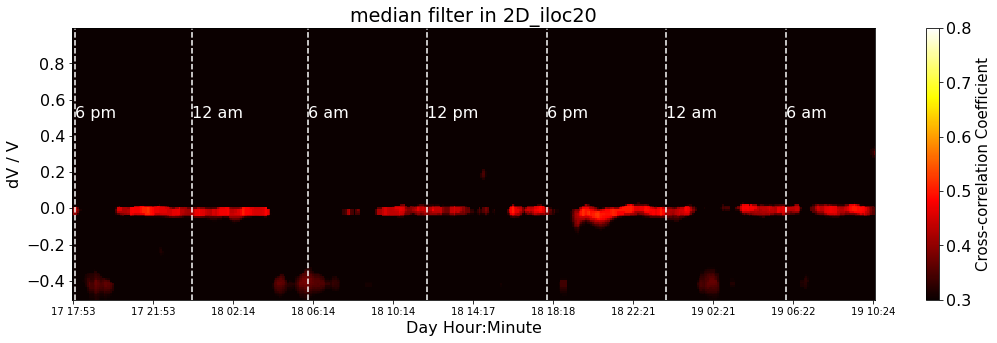

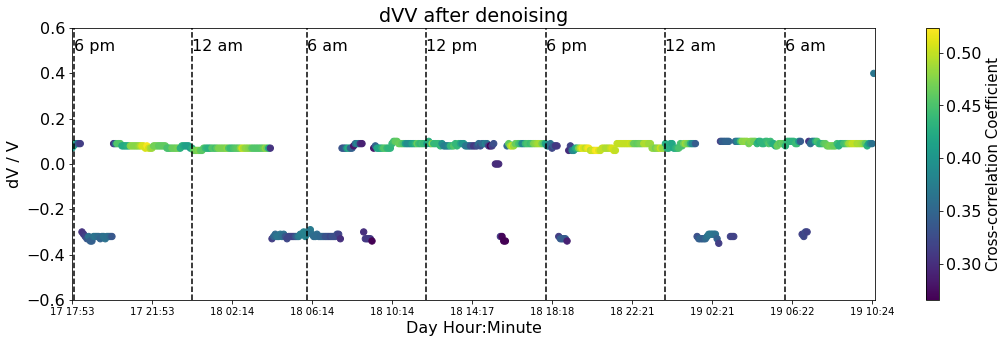

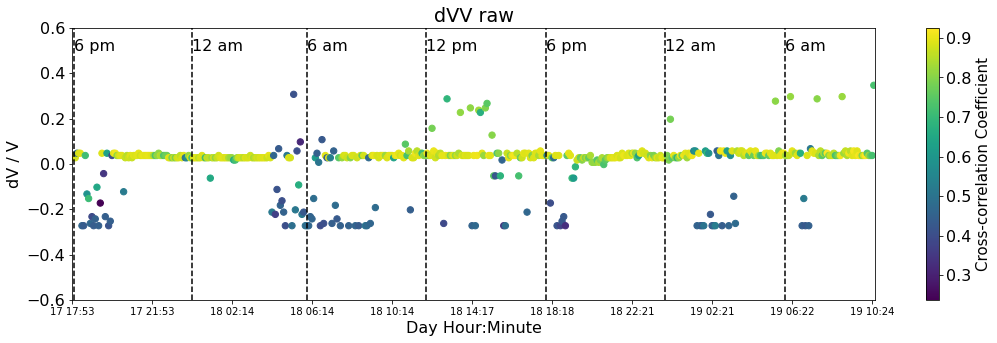

In [10]:
# for iloc in [2,6,16,22,30,44]:
for iloc in [20]:
# for iloc in range(51):
    data_plot=corr_all_time[iloc].T
    trunc_acf = data_plot[win_st:, :]
    trunc_stk = stack_stretch[iloc, :]/count
    strecthed_acfs = np.zeros_like(trunc_acf)
    for i in x:
        ratios, ccs = stretch_distribution(trunc_stk, trunc_acf[:,i], time, max_ratio=2)
        all_cc[iloc, :, i] = ccs 
        
    ######################
    # %% Use cone-filter
    filt_data, filtered_fk, fk2d = fk_filter_2cones(all_cc[iloc].T, w1=0.03, w2=0.005, cone1=True, cone2=False)
    # %% Use median-filter
    image = filt_data.real.T[:,:,np.newaxis]*200
    image = image - np.nanmin(image)
    denoised_image = cv2.medianBlur(image.astype(np.uint8), 7)/256
    #######################
    
    plt.figure(figsize=(18, 5))
    plt.pcolormesh(x, stretch_range-1, denoised_image, shading='auto', vmin=0.3, vmax=0.8, cmap = 'hot')
    plt.title('median filter in 2D_iloc' + str(iloc))
    plt.xticks(xax, hrax, fontsize = 10)
    bar=plt.colorbar()
    bar.set_label('Cross-correlation Coefficient', fontsize = 15)
    plt.xlabel("Day Hour:Minute", fontsize = 16)
    plt.ylabel("dV / V", fontsize = 16)
    for it in Ind6hrs:
        plt.axvline(x = it/5, color = 'w', linestyle='--')
    plt.text(Ind6hrs[0]/5, 0.5, '6 pm', color='w')
    plt.text(Ind6hrs[1]/5, 0.5, '12 am', color='w')
    plt.text(Ind6hrs[2]/5, 0.5, '6 am', color='w')
    plt.text(Ind6hrs[3]/5, 0.5, '12 pm', color='w')
    plt.text(Ind6hrs[4]/5, 0.5, '6 pm', color='w')
    plt.text(Ind6hrs[5]/5, 0.5, '12 am', color='w')
    plt.text(Ind6hrs[6]/5, 0.5, '6 am', color='w')

    
    ######################
    dvv_ind = np.argmax(denoised_image, axis=0)
    dvv = np.zeros(len(dvv_ind), dtype=np.float32)
    for i in range(len(dvv_ind)):
        dvv[i]= stretch_range[dvv_ind[i]]
    cc_dvv = np.nanmax(denoised_image, axis=0)
    ######################
    
    plt.figure(figsize=(18, 5))
    plt.scatter(x, dvv-np.mean(dvv), cmap='viridis', c=cc_dvv, s=40, marker='o')
    plt.xticks(xax, hrax, fontsize = 10)
    plt.title('dVV after denoising')
    plt.ylim(-0.6, 0.6)
    plt.xlim(0, x.shape[-1])
    bar=plt.colorbar()
    bar.set_label('Cross-correlation Coefficient', fontsize = 15)
    plt.xlabel("Day Hour:Minute", fontsize = 16)
    plt.ylabel("dV / V", fontsize = 16)
    for it in Ind6hrs:
        plt.axvline(x = it/5, color = 'k', linestyle='--')
    plt.text(Ind6hrs[0]/5, 0.5, '6 pm', color='k')
    plt.text(Ind6hrs[1]/5, 0.5, '12 am', color='k')
    plt.text(Ind6hrs[2]/5, 0.5, '6 am', color='k')
    plt.text(Ind6hrs[3]/5, 0.5, '12 pm', color='k')
    plt.text(Ind6hrs[4]/5, 0.5, '6 pm', color='k')
    plt.text(Ind6hrs[5]/5, 0.5, '12 am', color='k')
    plt.text(Ind6hrs[6]/5, 0.5, '6 am', color='k')

    # Raw dvv
    ######################
    with h5py.File('dvv_stretch_cc_25_50Hz.hdf5', 'r') as f:
        ratio_all = f['ratio'][:]
        cc_all = f['cc'][:]
    ######################
        
    plt.figure(figsize = (18, 5))
    plt.scatter(x, ratio_all[iloc]-np.mean(ratio_all[iloc]), cmap='viridis', c=np.array(cc_all[iloc]), s=40, marker='o')
    plt.xticks(xax, hrax, fontsize = 10)
    plt.title('dVV raw')
    plt.ylim(-0.6, 0.6)
    plt.xlim(0, x.shape[-1])
    bar=plt.colorbar()
    bar.set_label('Cross-correlation Coefficient', fontsize = 15)
    plt.xlabel("Day Hour:Minute", fontsize = 16)
    plt.ylabel("dV / V", fontsize = 16)
    for it in Ind6hrs:
        plt.axvline(x = it/5, color = 'k', linestyle='--')
    plt.text(Ind6hrs[0]/5, 0.5, '6 pm', color='k')
    plt.text(Ind6hrs[1]/5, 0.5, '12 am', color='k')
    plt.text(Ind6hrs[2]/5, 0.5, '6 am', color='k')
    plt.text(Ind6hrs[3]/5, 0.5, '12 pm', color='k')
    plt.text(Ind6hrs[4]/5, 0.5, '6 pm', color='k')
    plt.text(Ind6hrs[5]/5, 0.5, '12 am', color='k')
    plt.text(Ind6hrs[6]/5, 0.5, '6 am', color='k')

### Enhance all channels and get reference dvv

In [10]:
# 2D space time of dvv
time = y[win_st:win_st+75] / samp_freq

all_dvv = np.zeros((51, len(x)), dtype = np.float32)
all_cc = np.zeros((51, len(stretch_range), len(x)), dtype = np.float32)

for iloc in range(51):
    data_plot=corr_all_time[iloc].T
    trunc_acf = data_plot[win_st:win_st+75, :]
    trunc_stk = stack_stretch[iloc, :75]/count
    strecthed_acfs = np.zeros_like(trunc_acf)
    for i in x:
        ratios, ccs = stretch_distribution(trunc_stk, trunc_acf[:,i], time, max_ratio=2)
        all_cc[iloc, :, i] = ccs 
        
    ######################
    ## Denoising
    # %% Use cone-filter
    filt_data, filtered_fk, fk2d = fk_filter_2cones(all_cc[iloc].T, w1=0.03, w2=0.005, cone1=True, cone2=False)
    image = filt_data.real.T[:,:,np.newaxis]*200
    image = image - np.nanmin(image)
    denoised_image = cv2.medianBlur(image.astype(np.uint8), 7)/256
    #######################
    
#     plt.figure(figsize=(18, 5))
#     plt.pcolormesh(x, stretch_range-1, denoised_image, shading='auto', vmin=0.3, vmax=0.8, cmap = 'hot')
#     plt.title('median filter in 2D_iloc' + str(iloc))
#     plt.xticks(xax, hrax, fontsize = 10)
#     bar=plt.colorbar()
#     bar.set_label('Cross-correlation Coefficient', fontsize = 15)
#     plt.xlabel("Day Hour:Minute", fontsize = 16)
#     plt.ylabel("dV / V", fontsize = 16)
#     for it in Ind6hrs:
#         plt.axvline(x = it/5, color = 'w', linestyle='--')
#     plt.text(Ind6hrs[0]/5, 0.5, '6 pm', color='w')
#     plt.text(Ind6hrs[1]/5, 0.5, '12 am', color='w')
#     plt.text(Ind6hrs[2]/5, 0.5, '6 am', color='w')
#     plt.text(Ind6hrs[3]/5, 0.5, '12 pm', color='w')
#     plt.text(Ind6hrs[4]/5, 0.5, '6 pm', color='w')
#     plt.text(Ind6hrs[5]/5, 0.5, '12 am', color='w')
#     plt.text(Ind6hrs[6]/5, 0.5, '6 am', color='w')
    
    ######################
    dvv_ind = np.argmax(denoised_image, axis=0)
    for i in range(len(dvv_ind)):
        all_dvv[iloc, i]= stretch_range[dvv_ind[i]]
    cc_dvv = np.nanmax(denoised_image, axis=0)
    ######################
    
#     plt.figure(figsize=(18, 5))
#     plt.scatter(x, all_dvv[iloc]-np.mean(all_dvv[iloc]), cmap='viridis', c=cc_dvv, s=40, marker='o')
#     plt.xticks(xax, hrax, fontsize = 10)
#     plt.title('dVV after denoising')
#     plt.ylim(-0.6, 0.6)
#     plt.xlim(0, x.shape[-1])
#     bar=plt.colorbar()
#     bar.set_label('Cross-correlation Coefficient', fontsize = 15)
#     plt.xlabel("Day Hour:Minute", fontsize = 16)
#     plt.ylabel("dV / V", fontsize = 16)
#     # Time frames
#     for it in Ind6hrs:
#         plt.axvline(x = it/5, color = 'k', linestyle='--')
#     plt.text(Ind6hrs[0]/5, 0.5, '6 pm', color='k')
#     plt.text(Ind6hrs[1]/5, 0.5, '12 am', color='k')
#     plt.text(Ind6hrs[2]/5, 0.5, '6 am', color='k')
#     plt.text(Ind6hrs[3]/5, 0.5, '12 pm', color='k')
#     plt.text(Ind6hrs[4]/5, 0.5, '6 pm', color='k')
#     plt.text(Ind6hrs[5]/5, 0.5, '12 am', color='k')
#     plt.text(Ind6hrs[6]/5, 0.5, '6 am', color='k')

### Refine dvv bounds using the reference dvv

/tmp/ipykernel_190177/4002336505.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(18, 5))


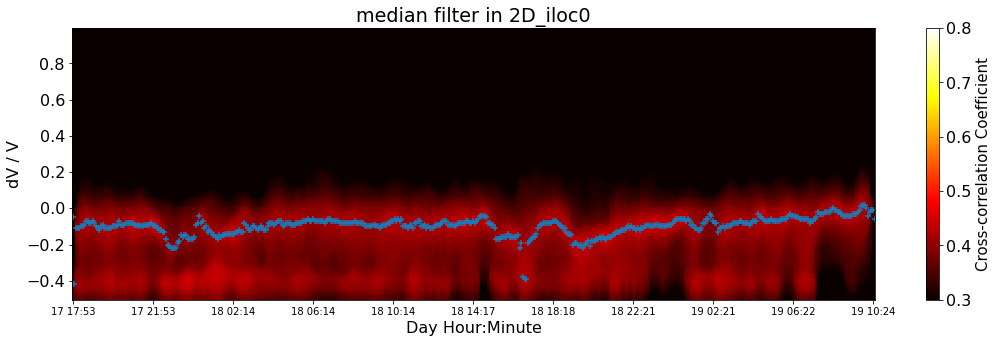

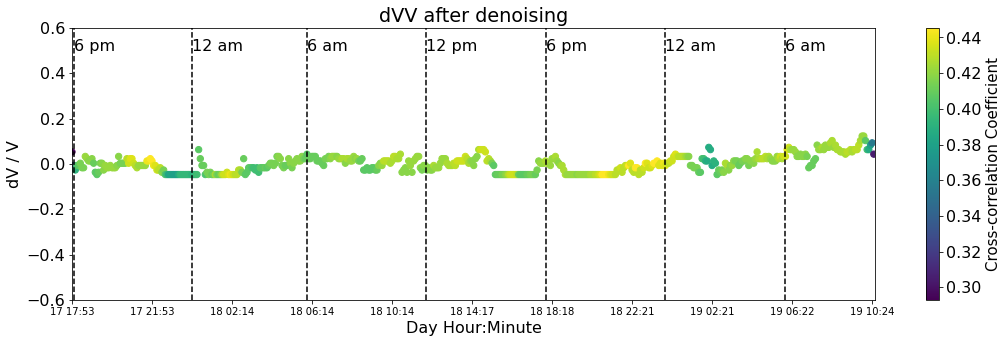

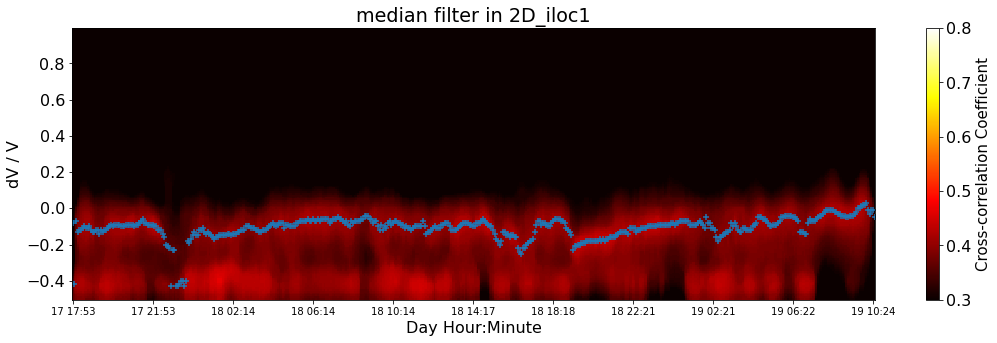

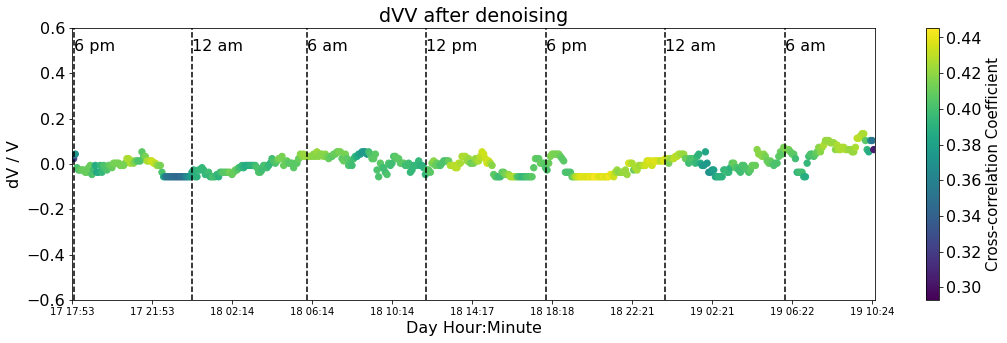

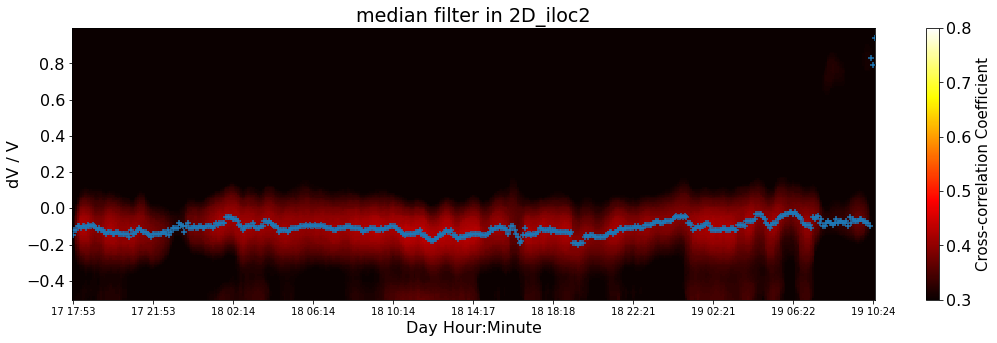

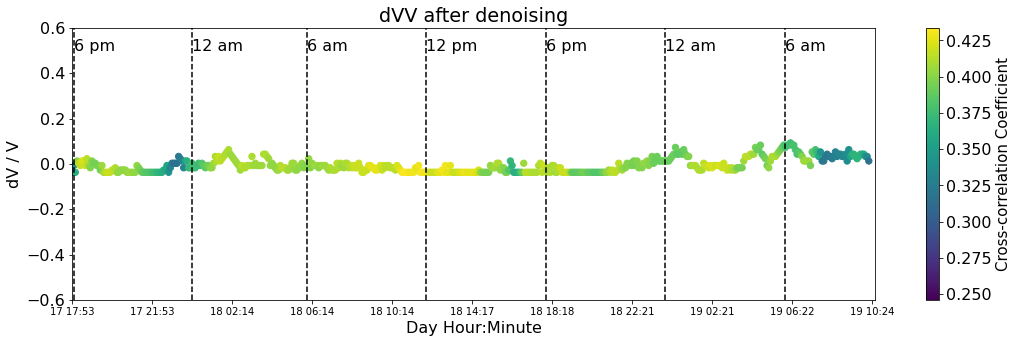

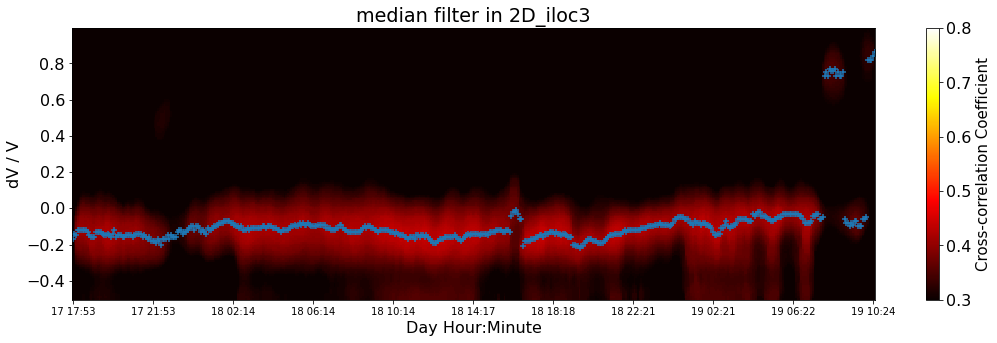

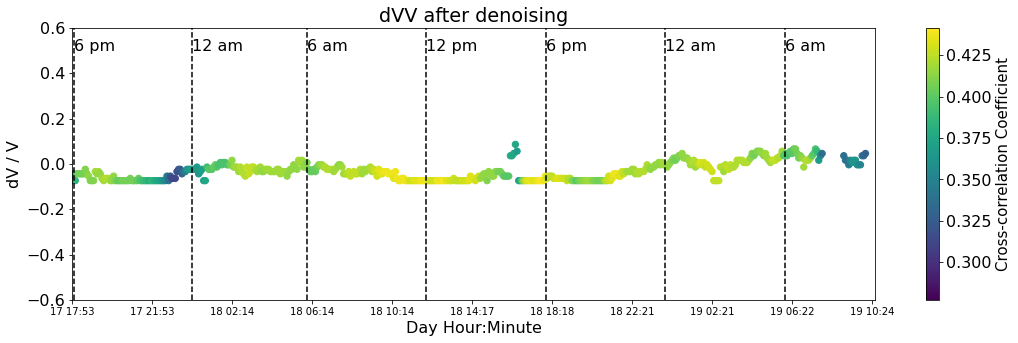

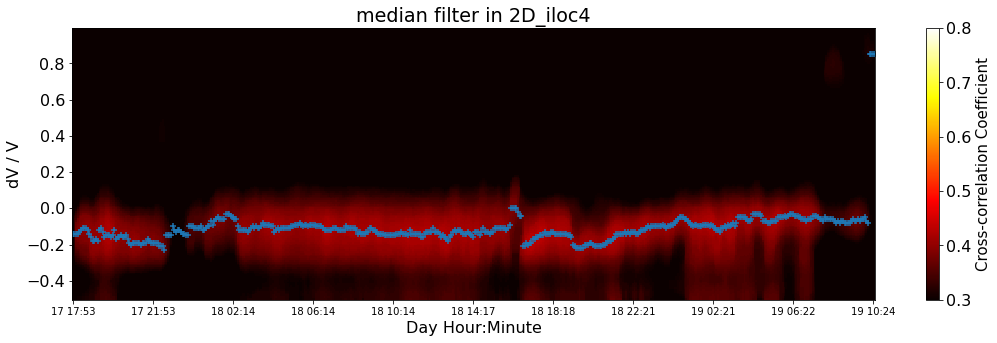

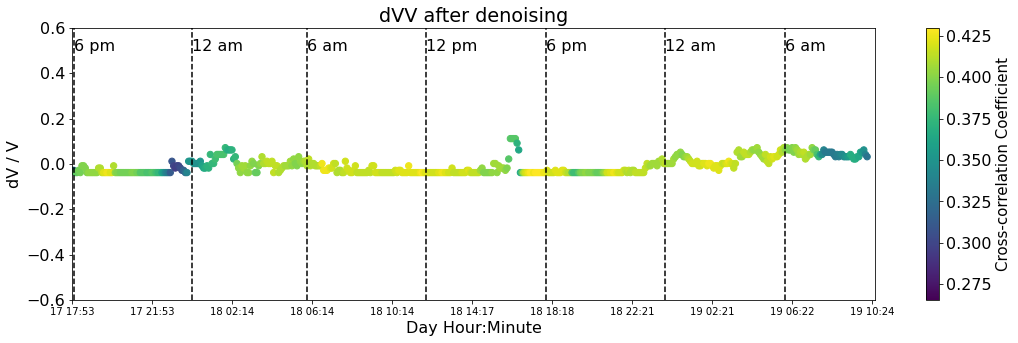

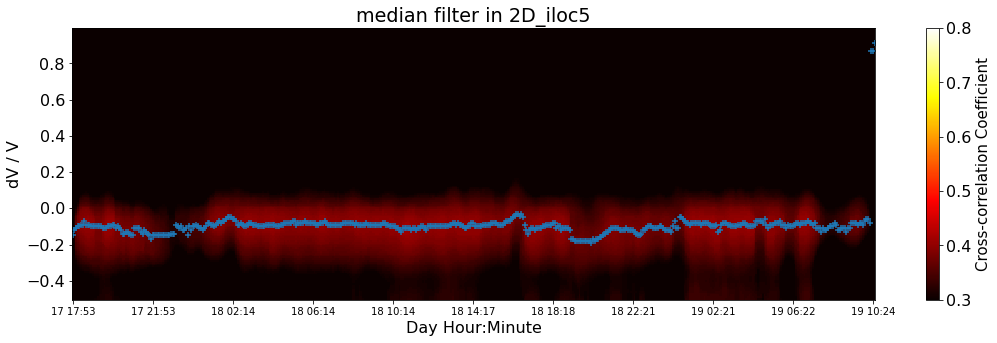

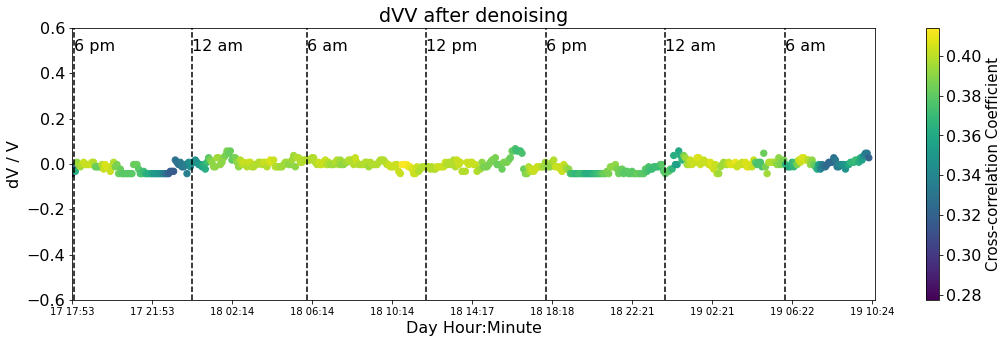

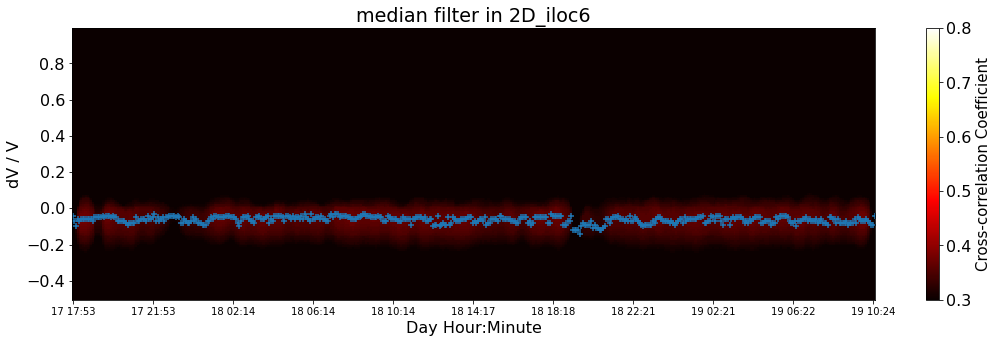

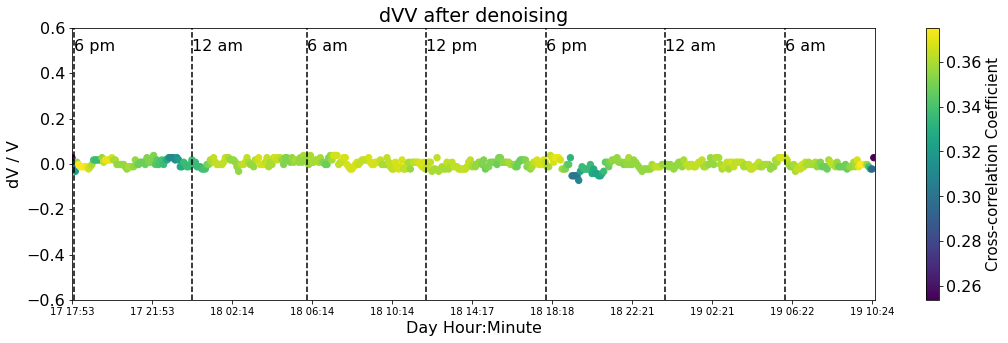

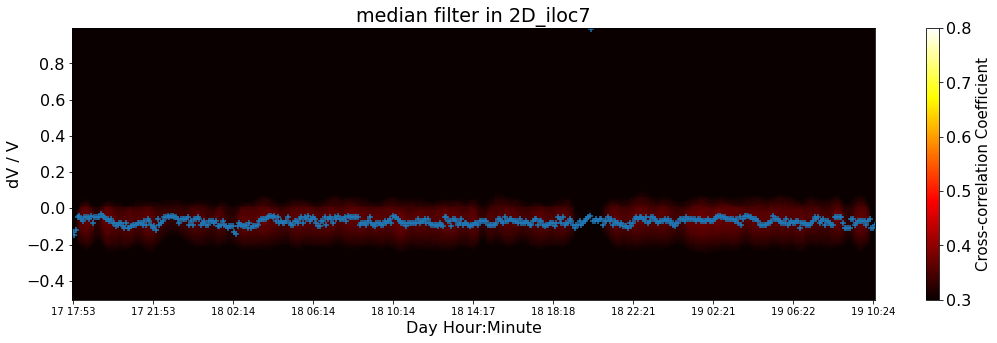

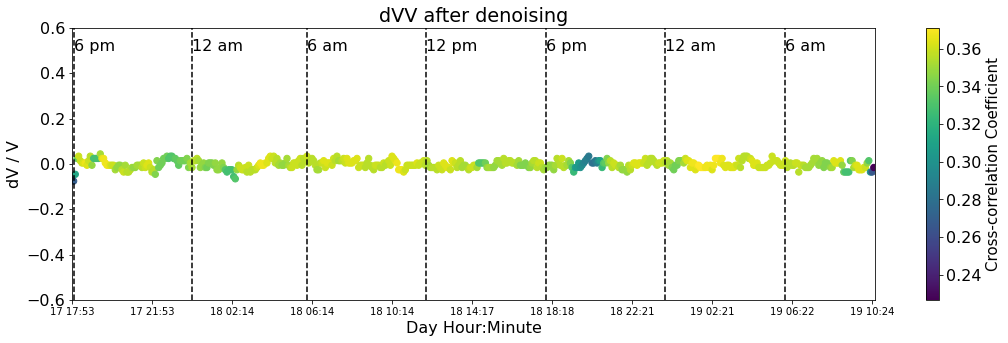

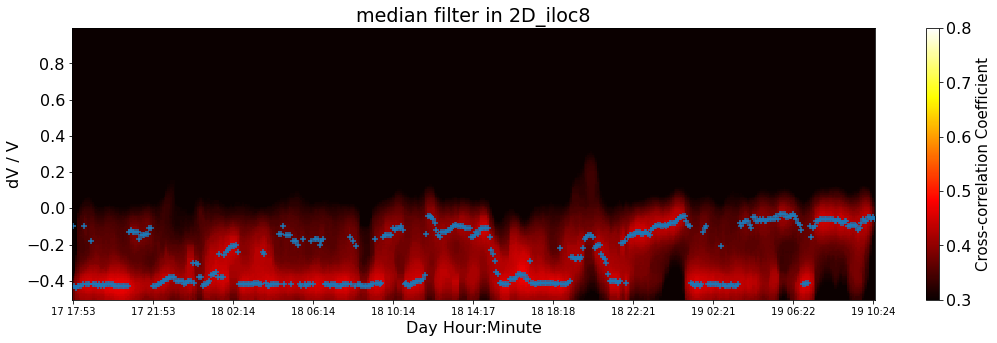

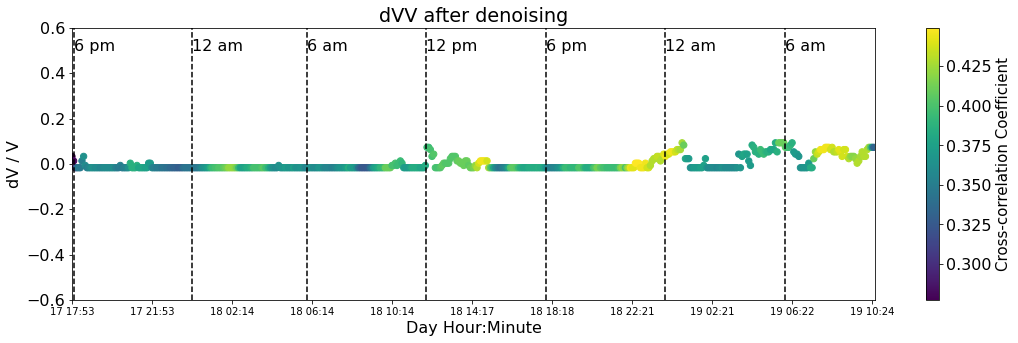

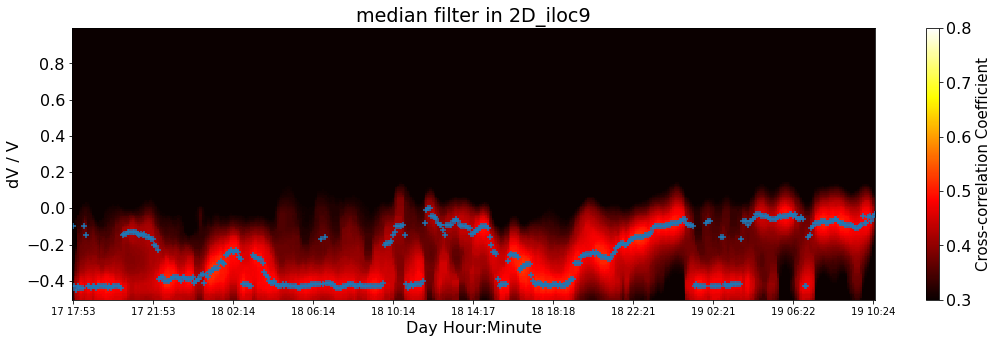

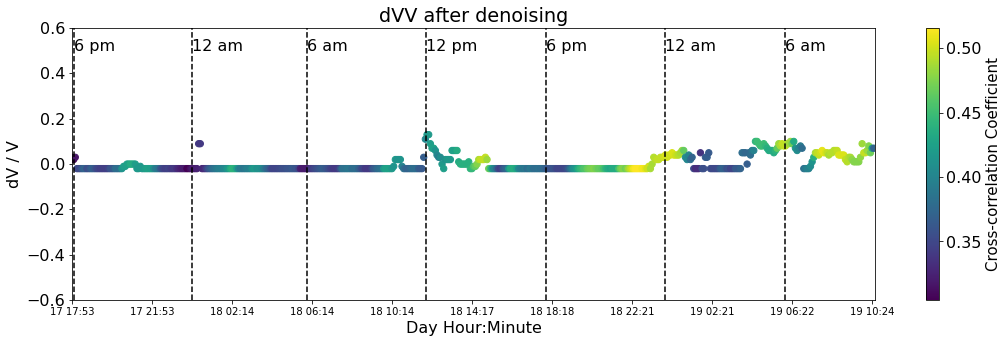

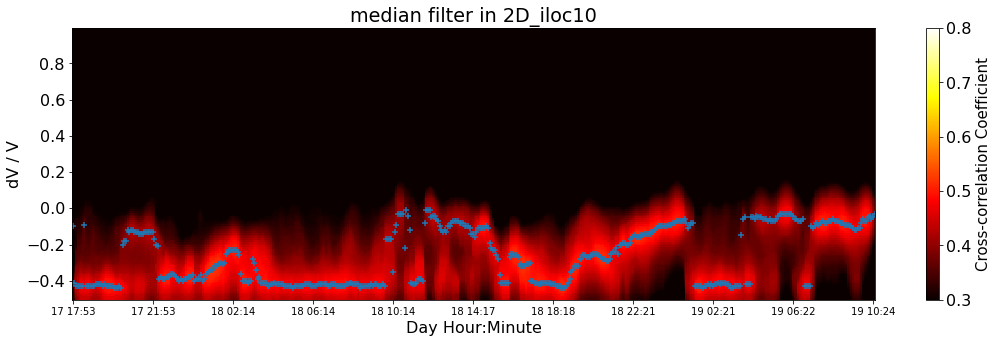

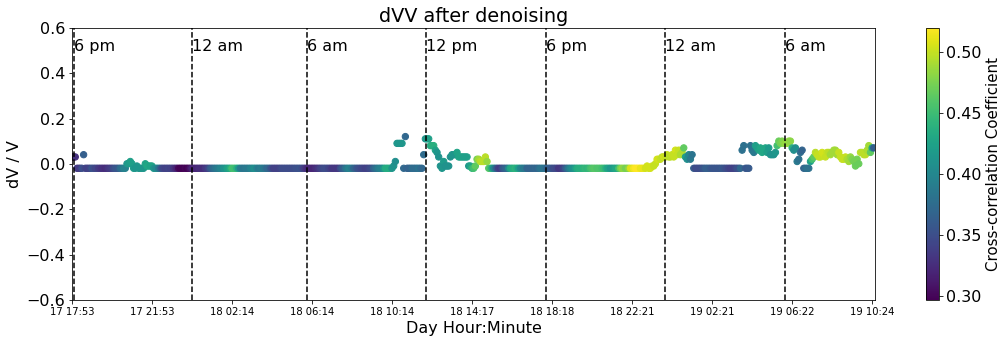

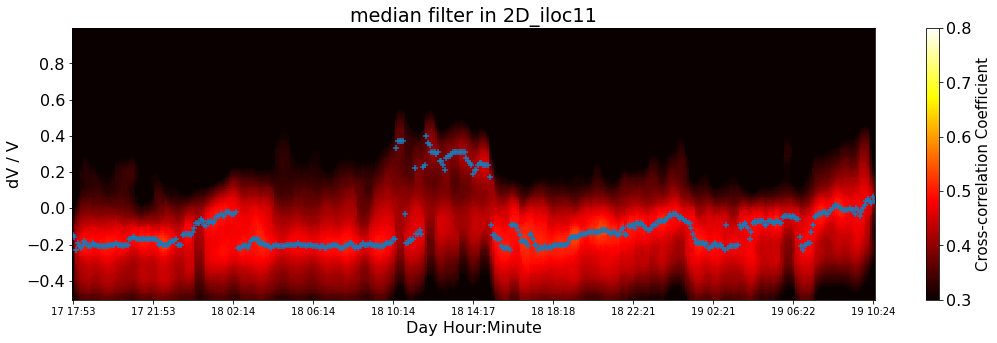

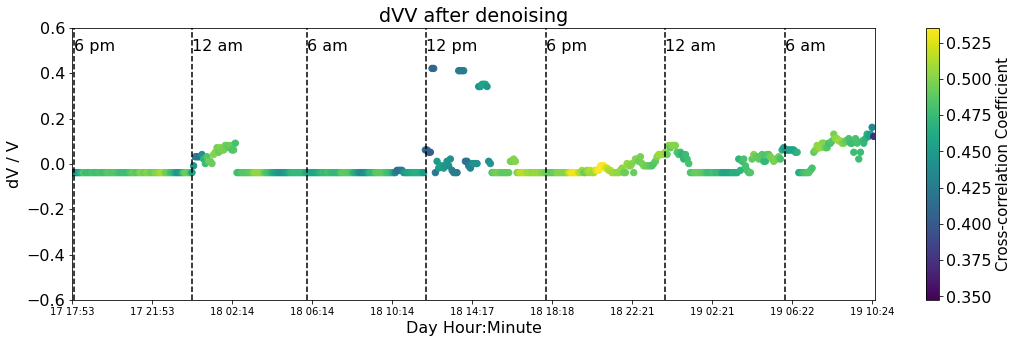

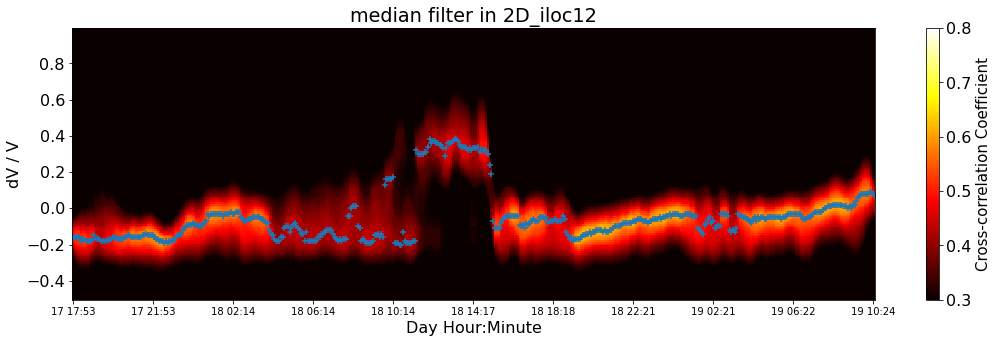

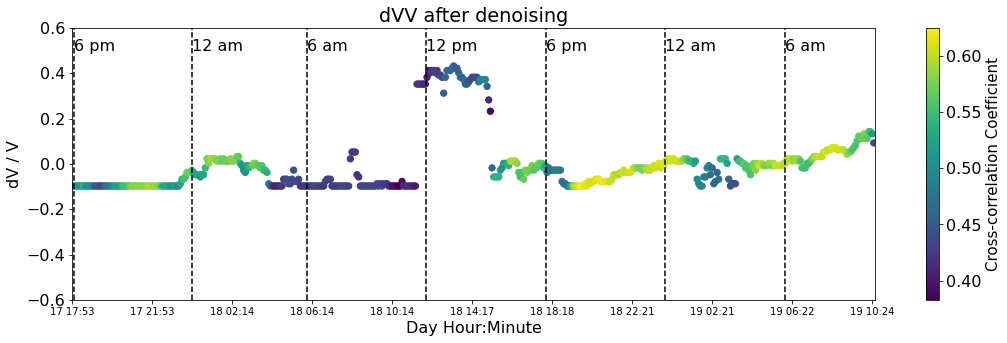

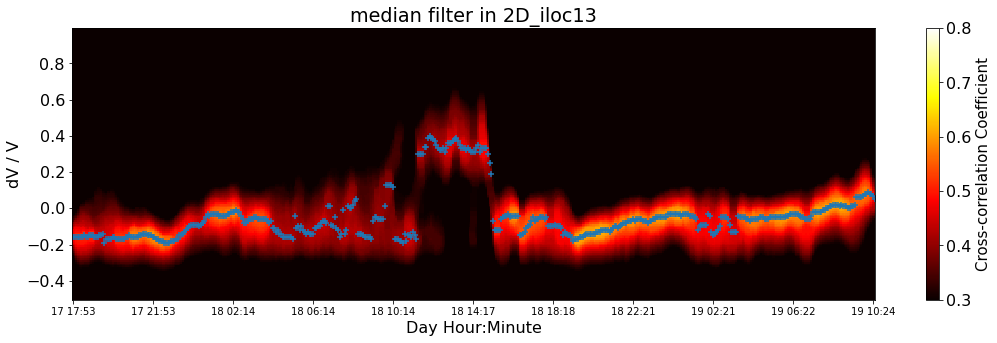

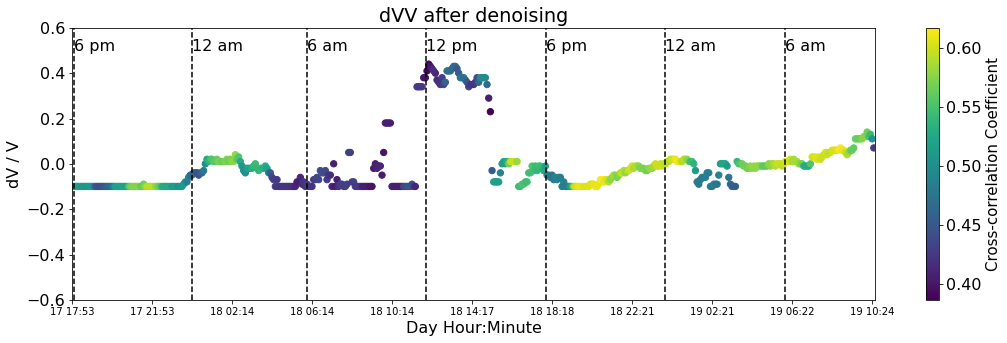

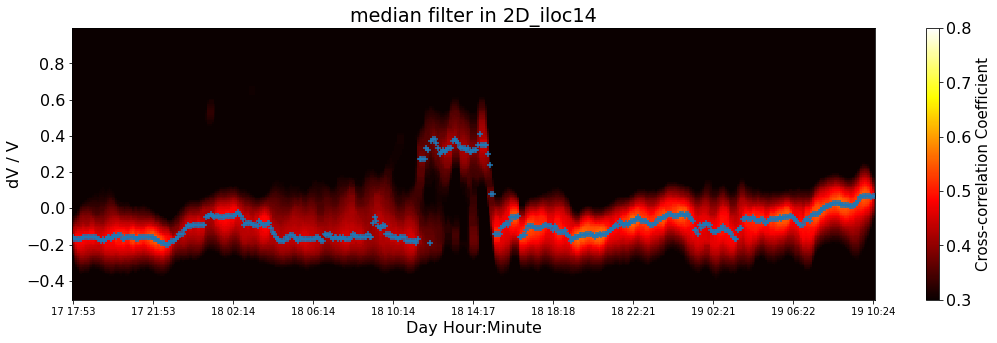

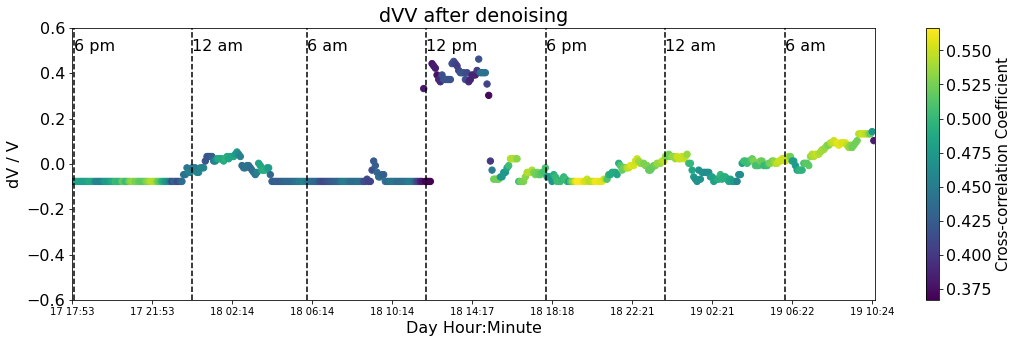

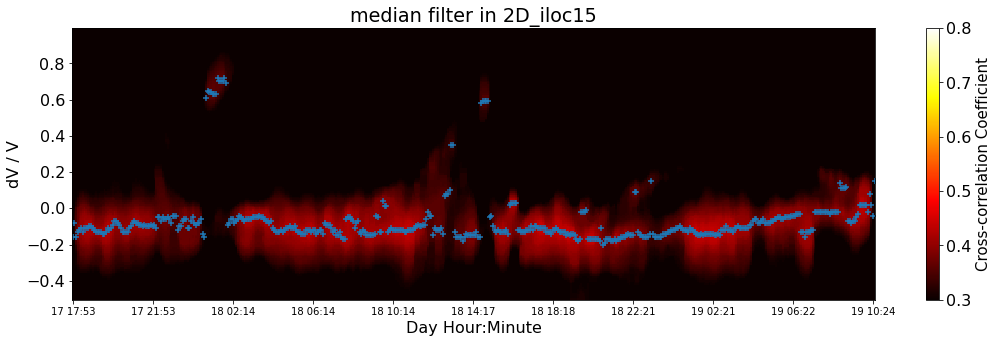

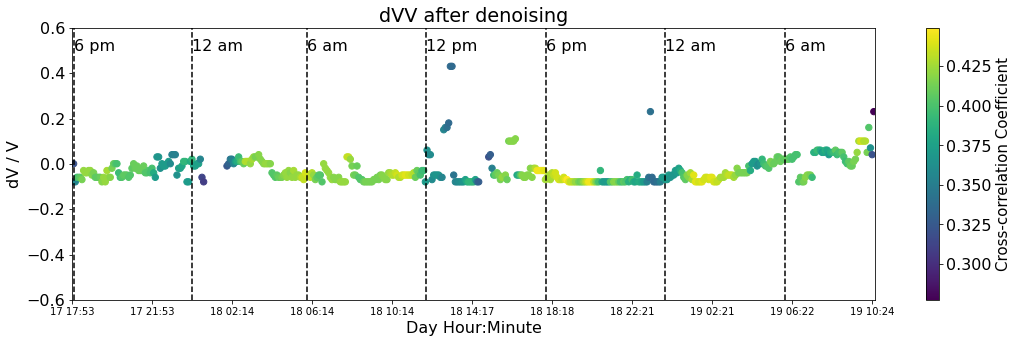

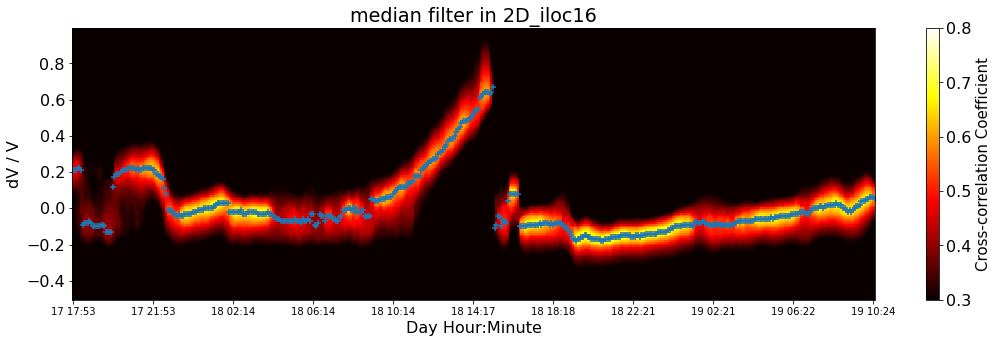

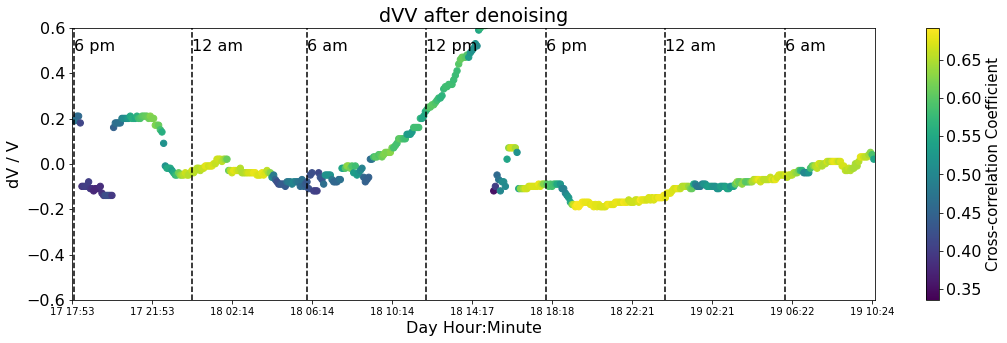

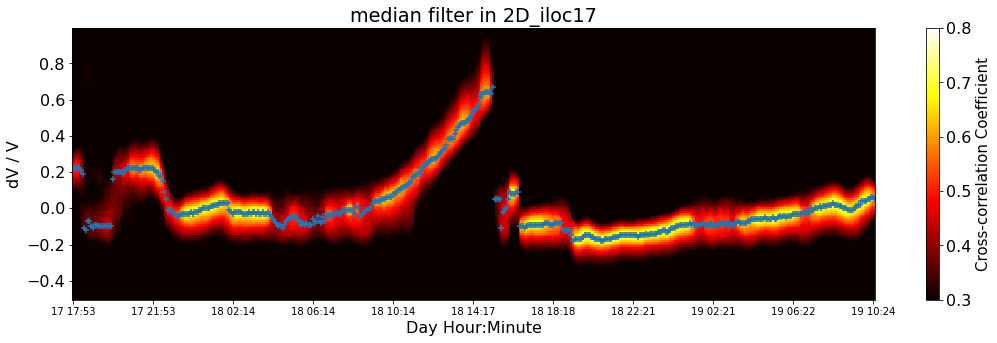

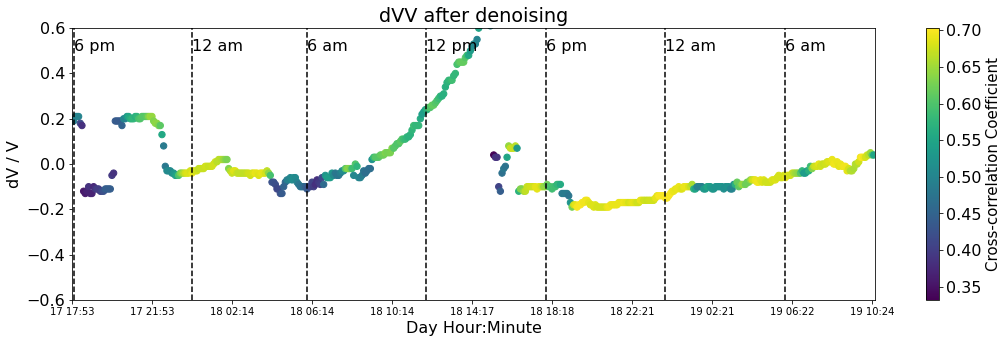

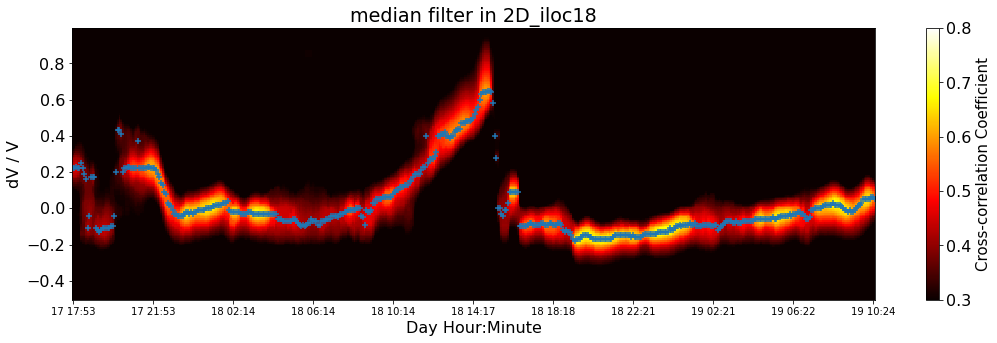

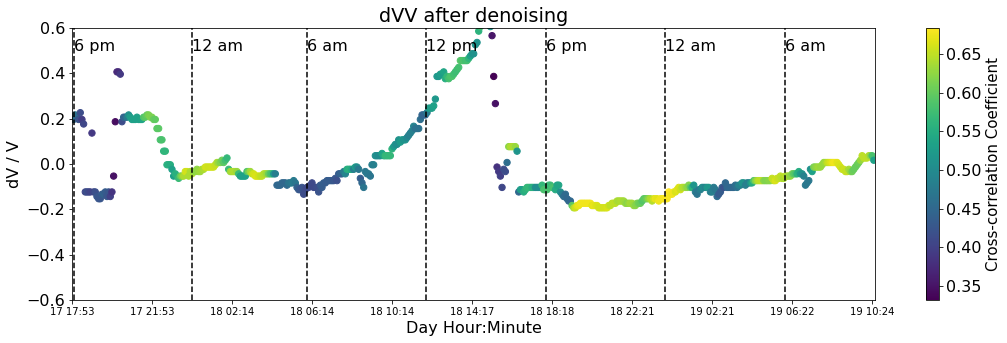

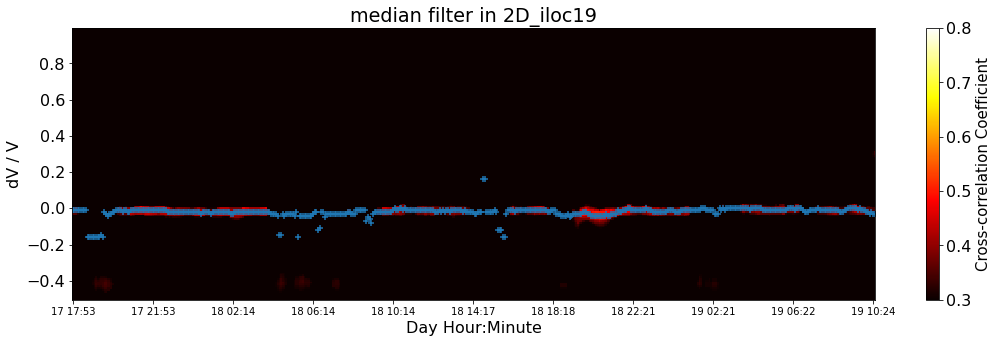

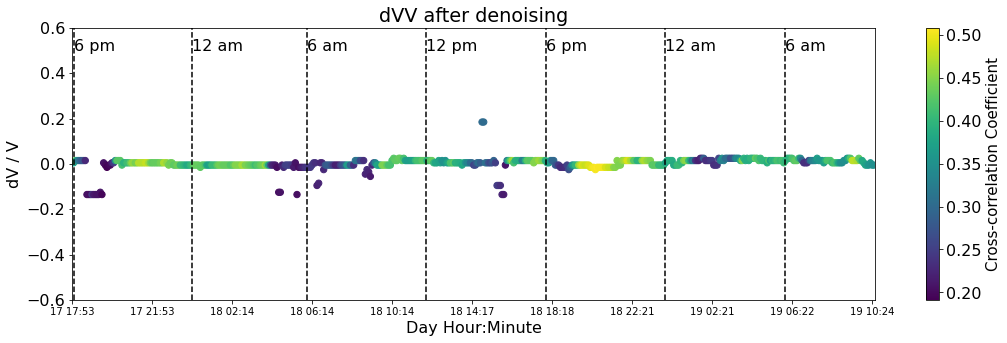

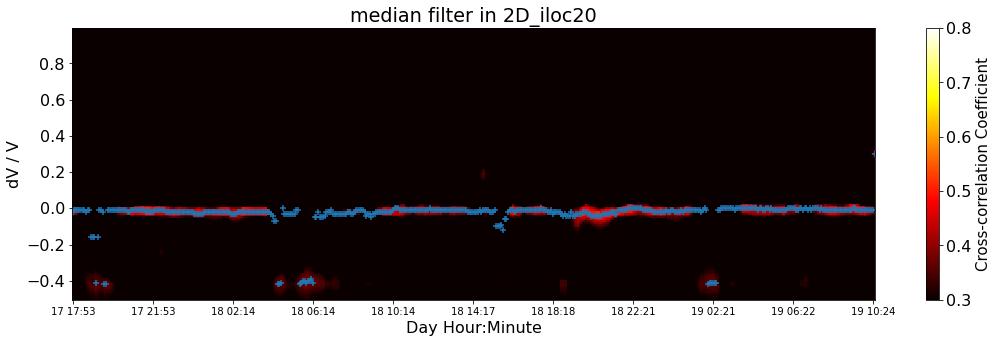

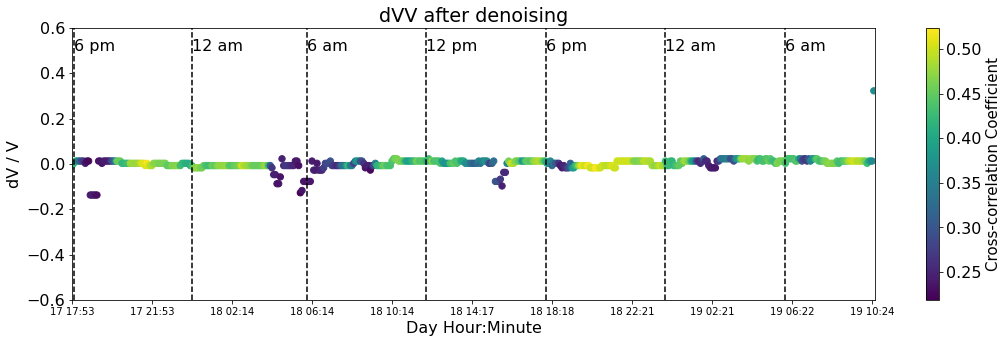

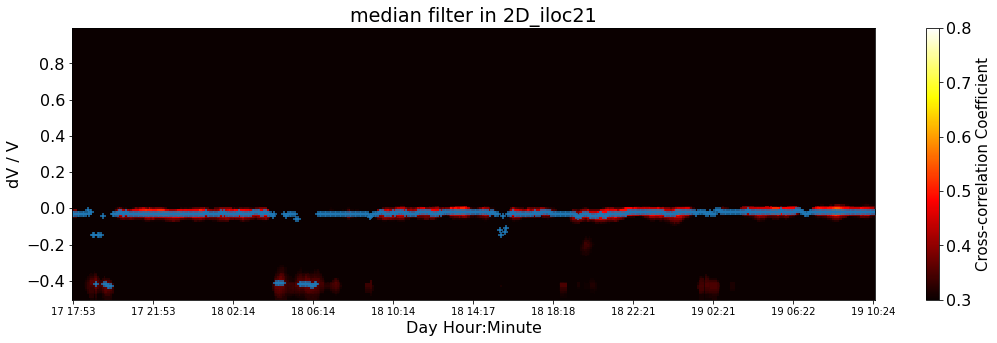

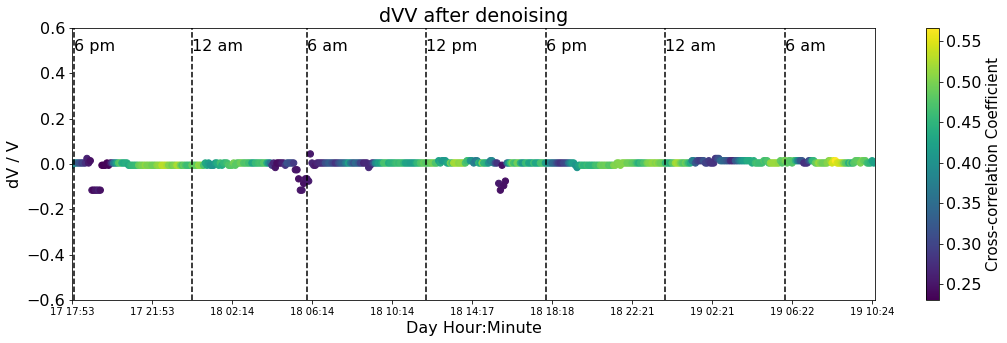

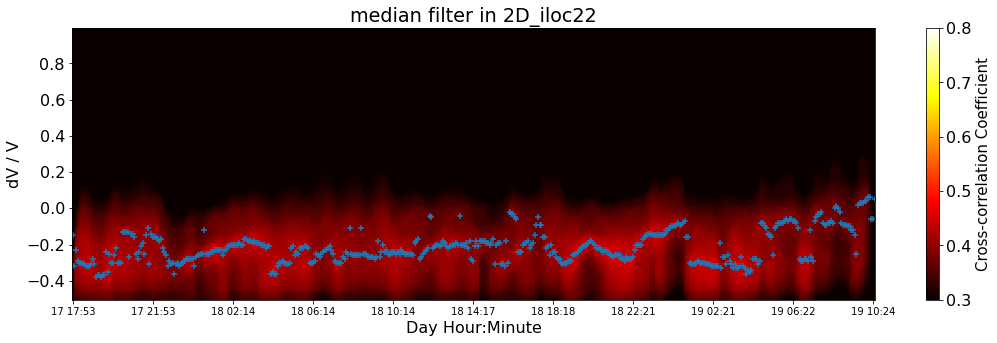

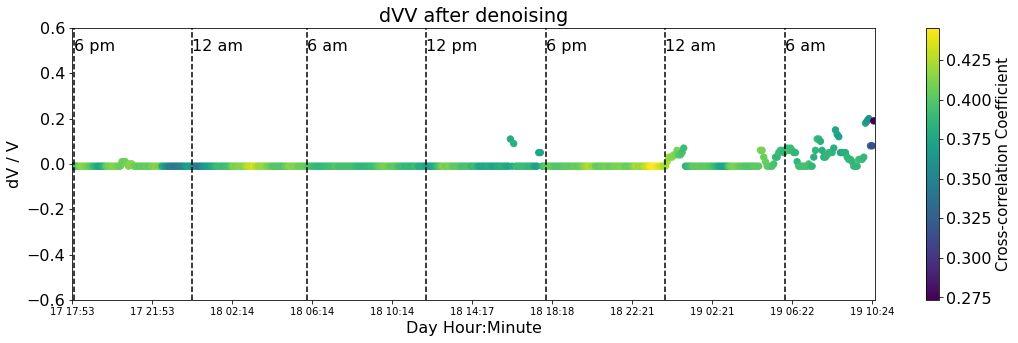

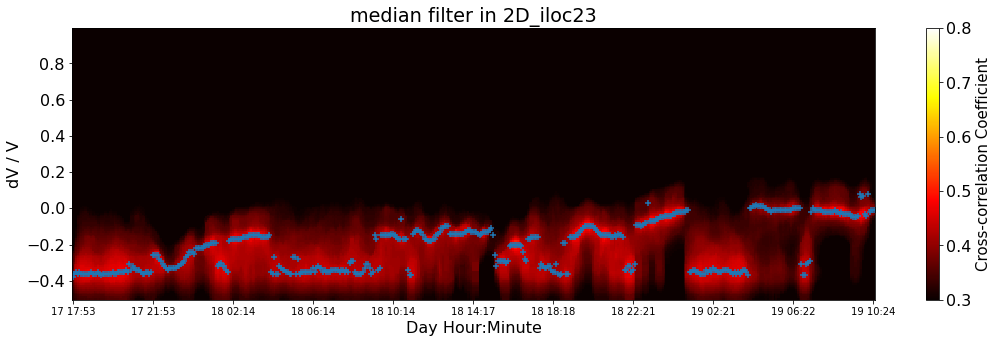

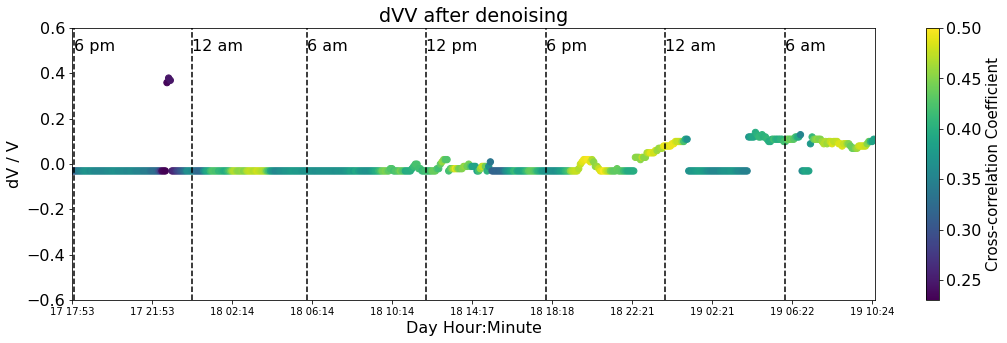

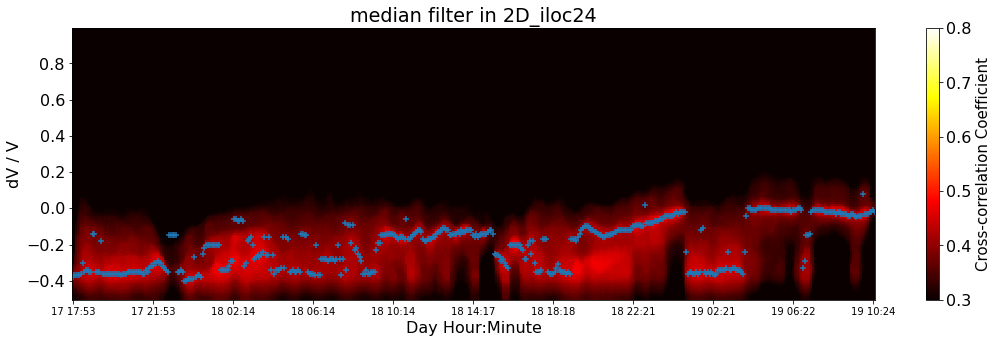

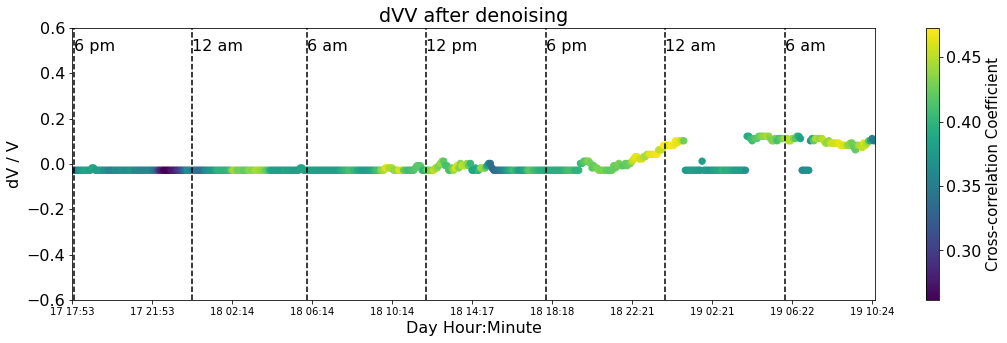

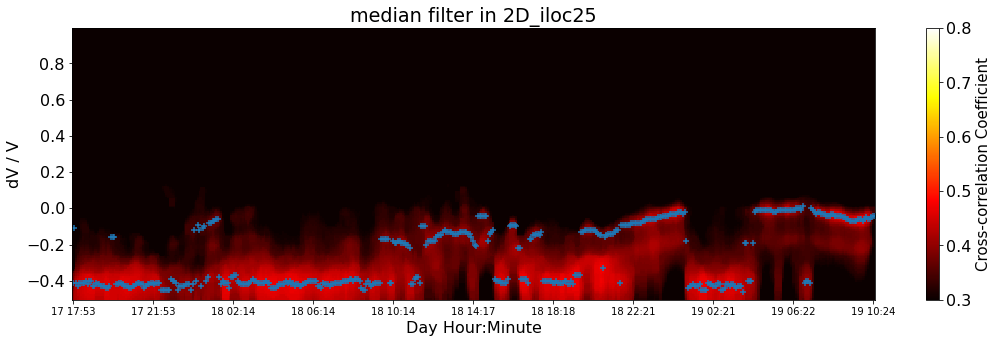

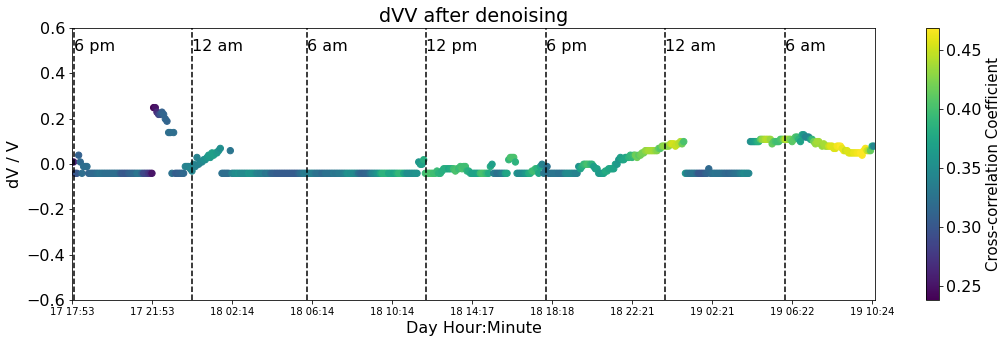

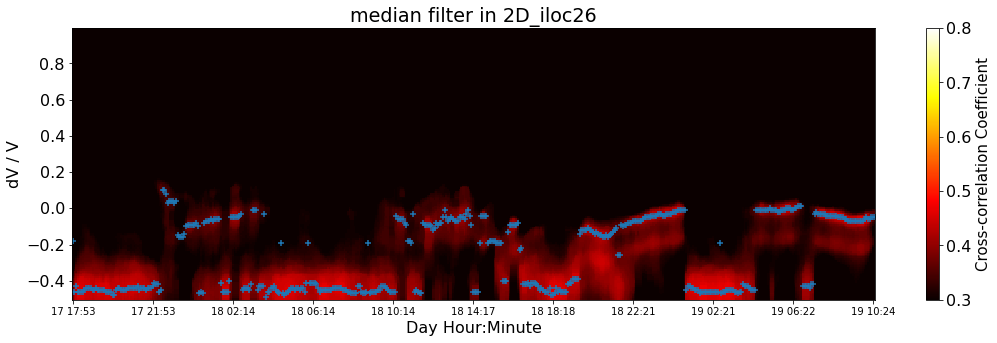

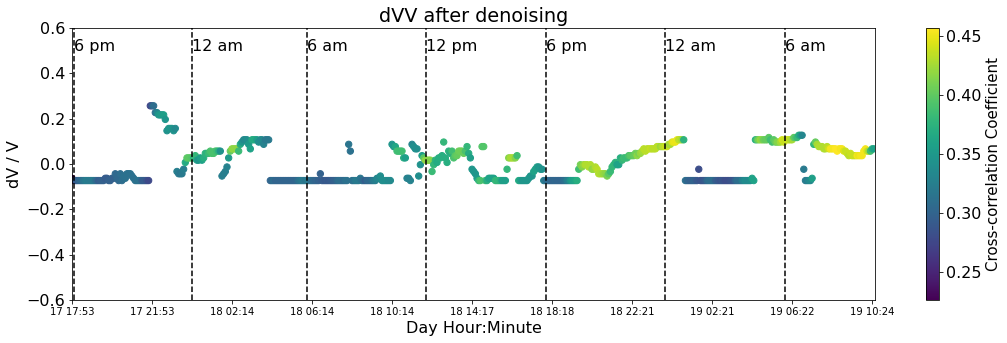

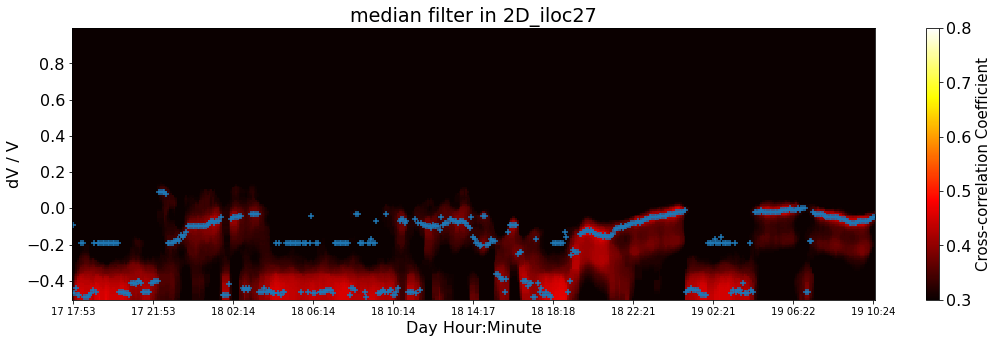

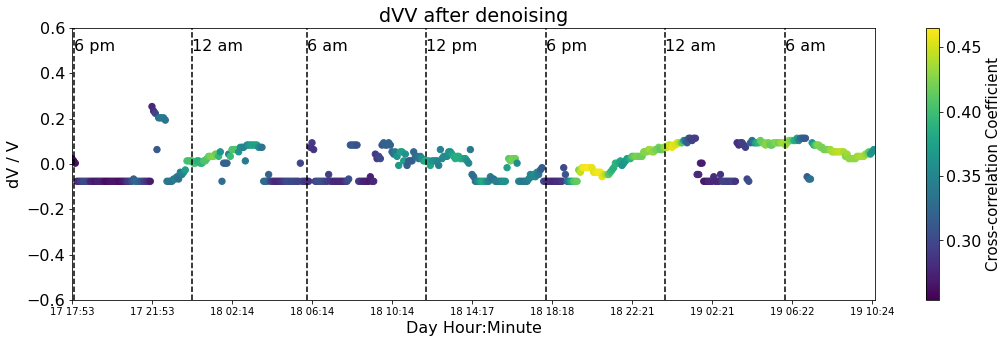

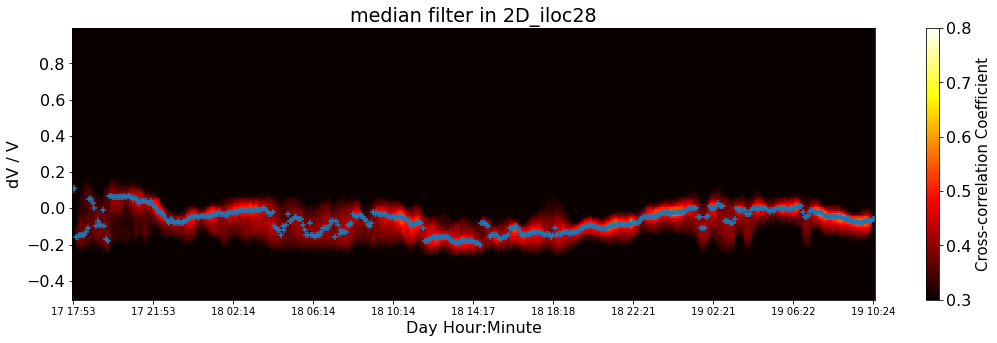

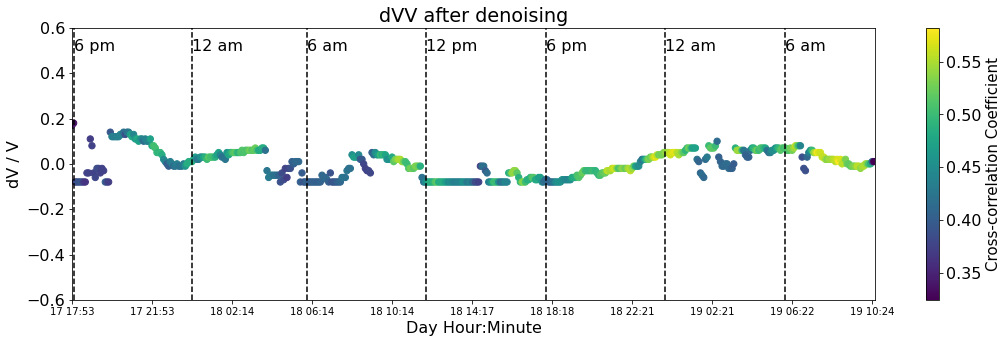

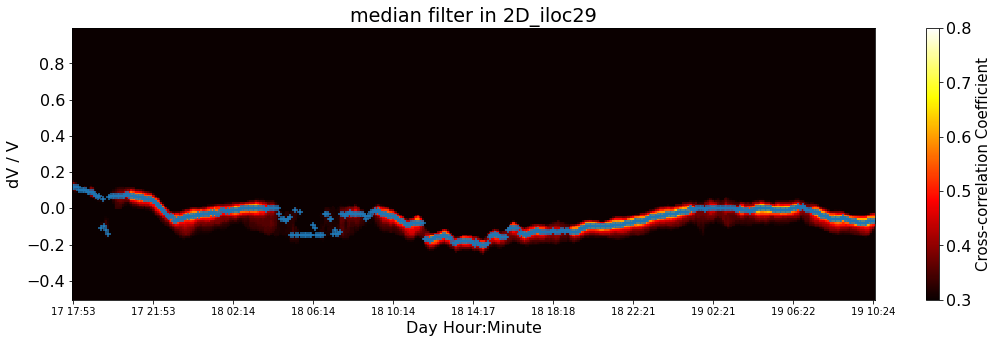

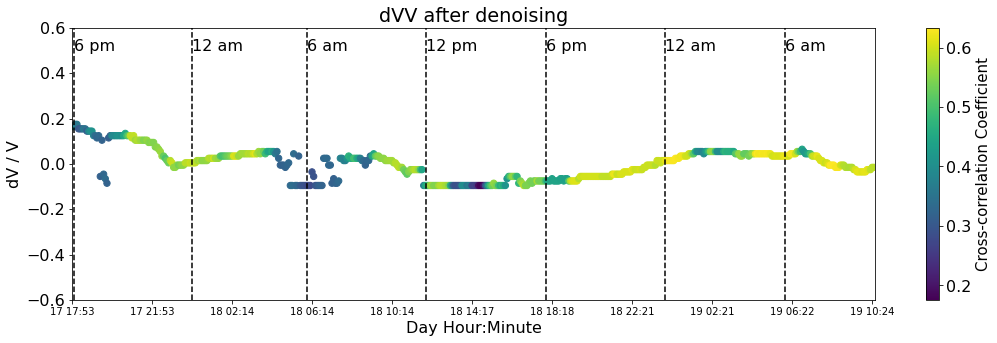

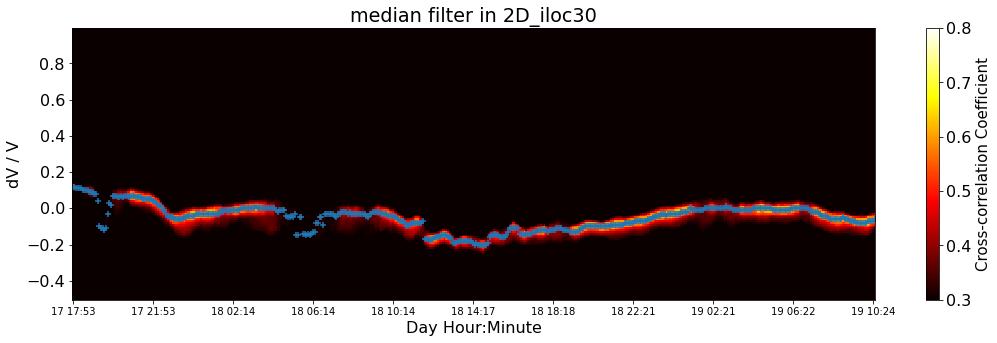

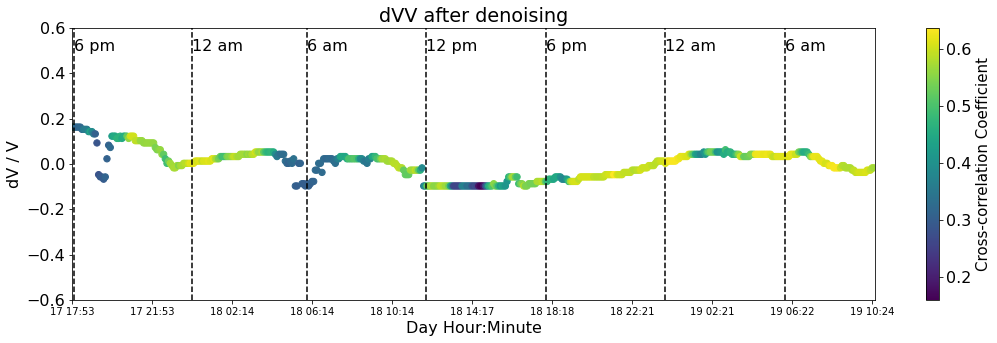

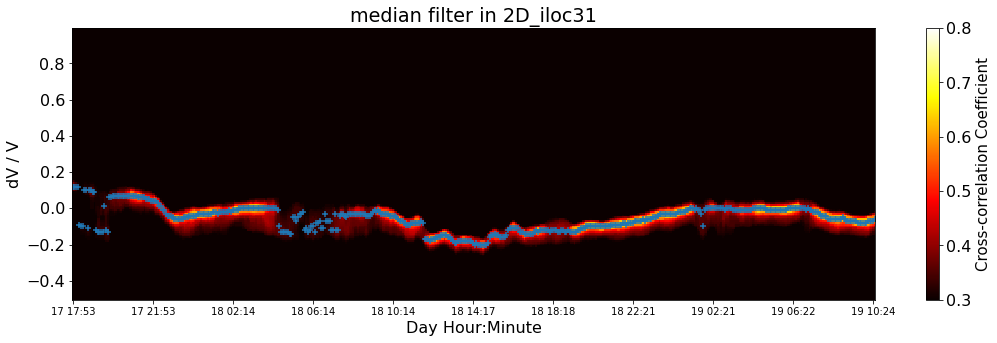

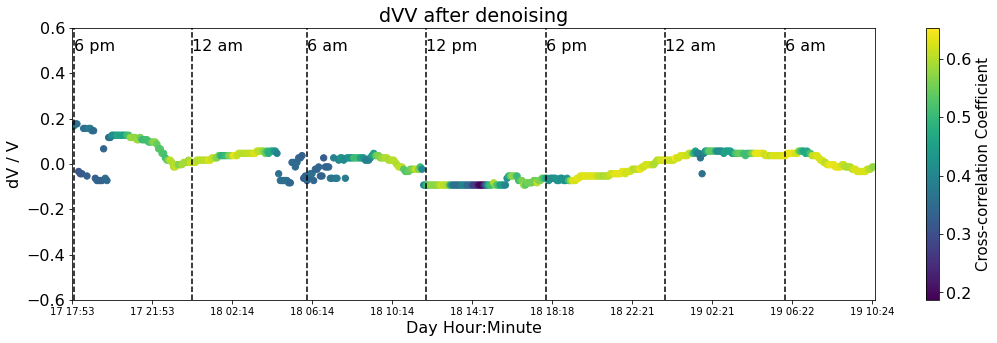

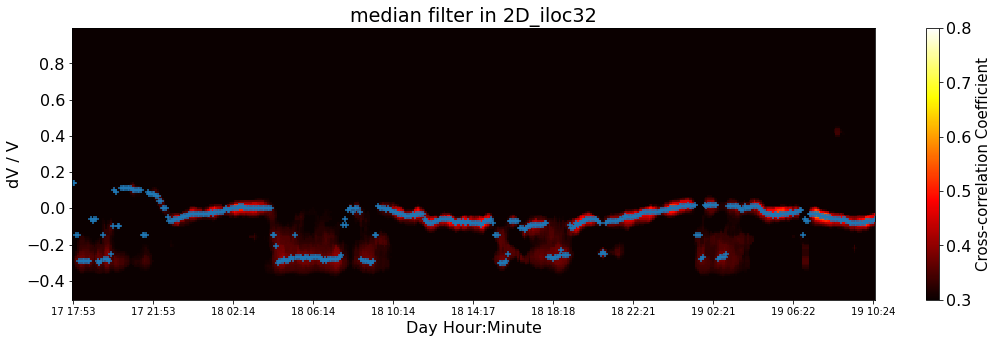

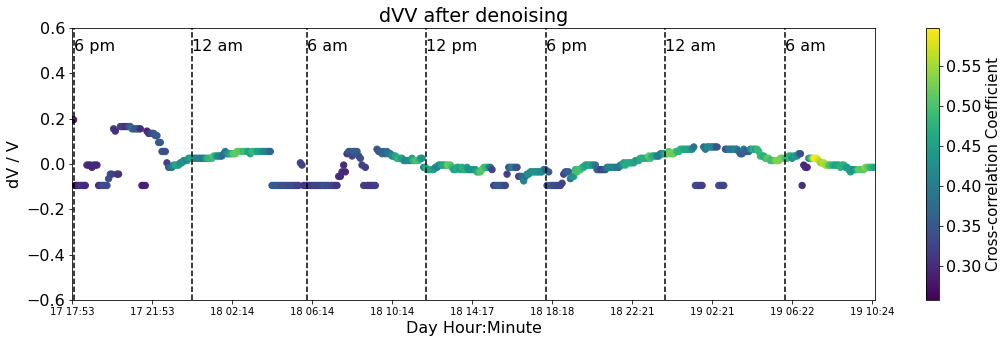

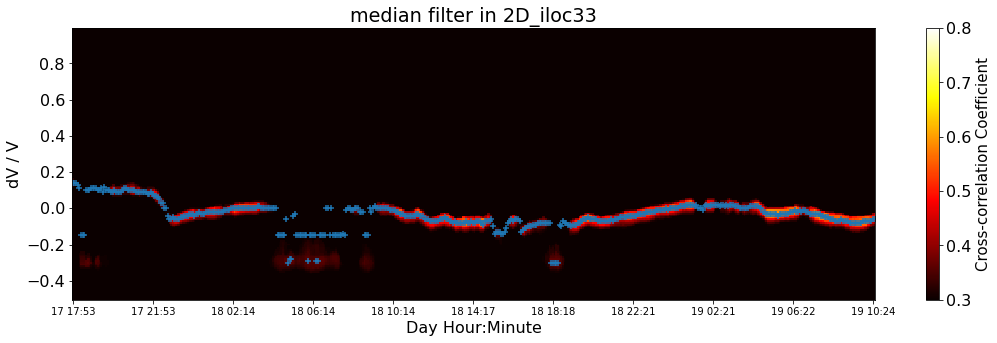

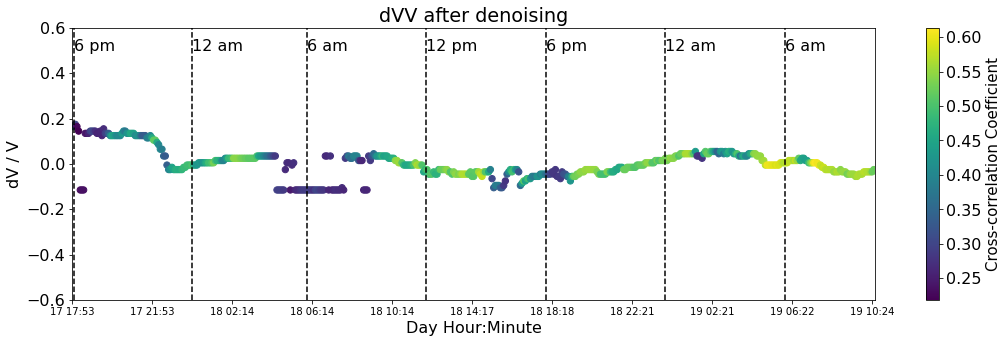

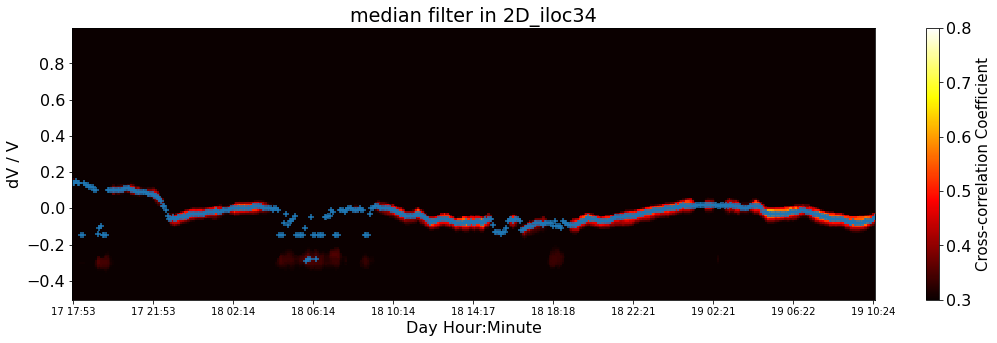

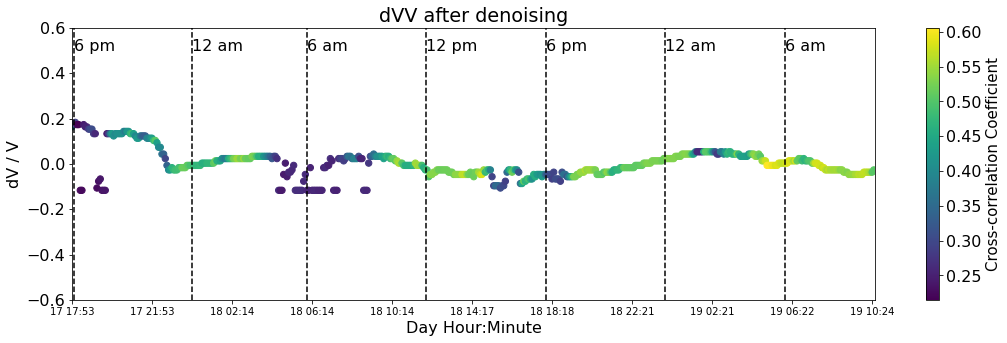

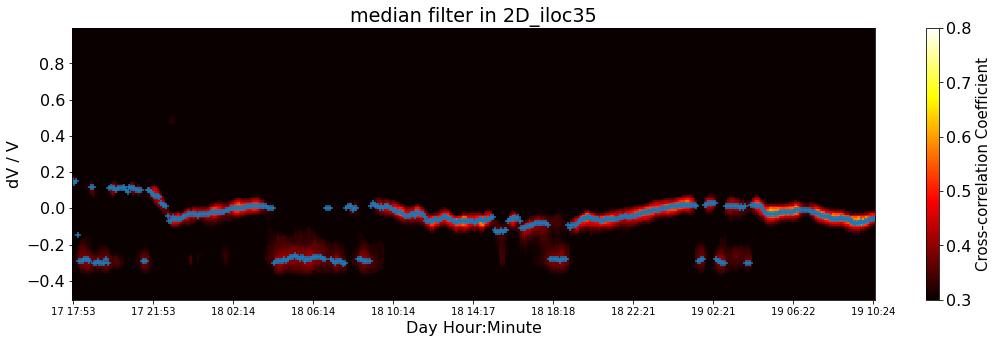

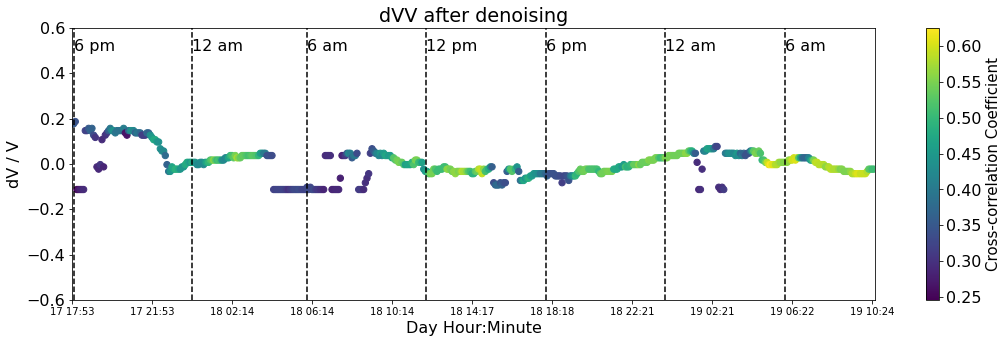

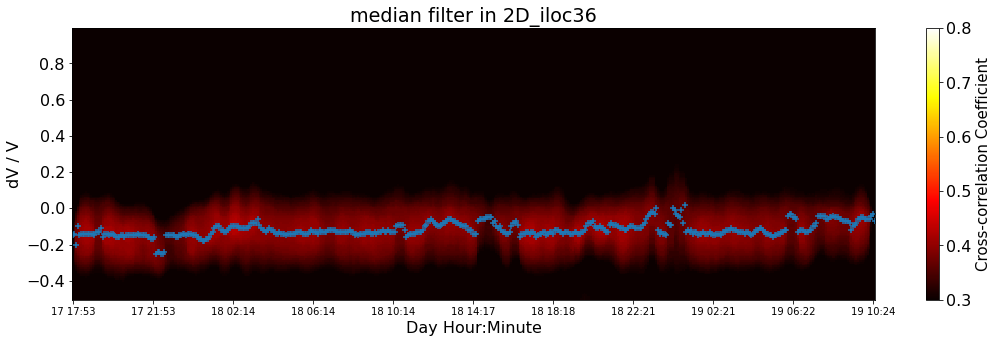

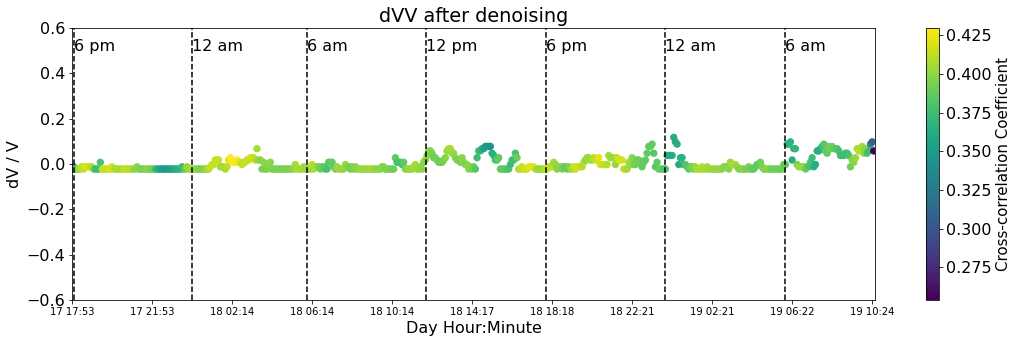

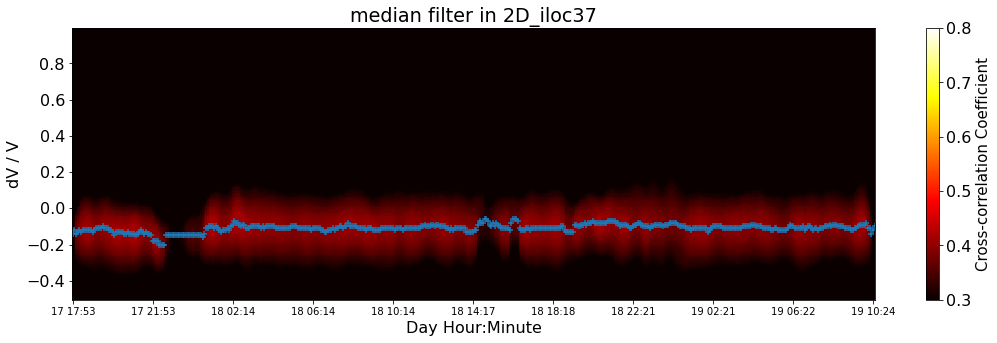

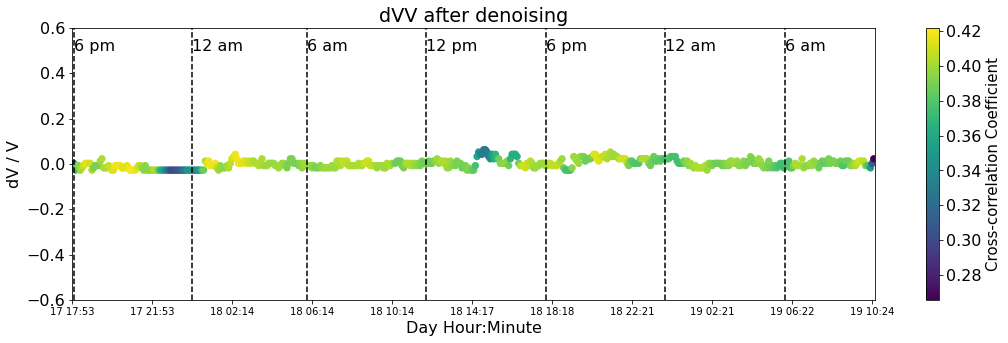

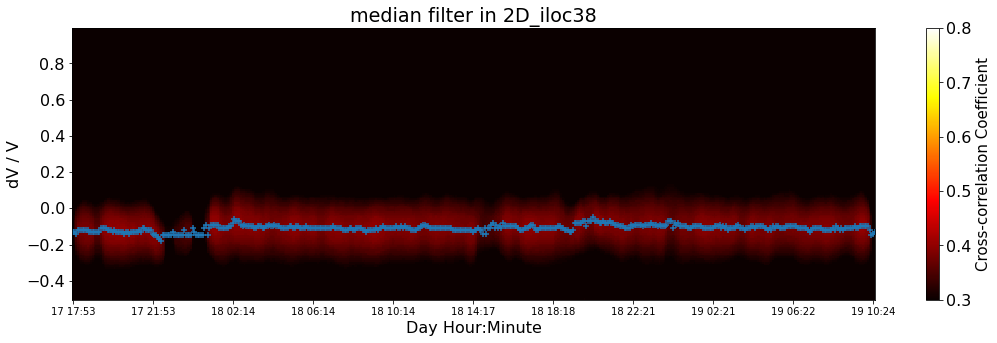

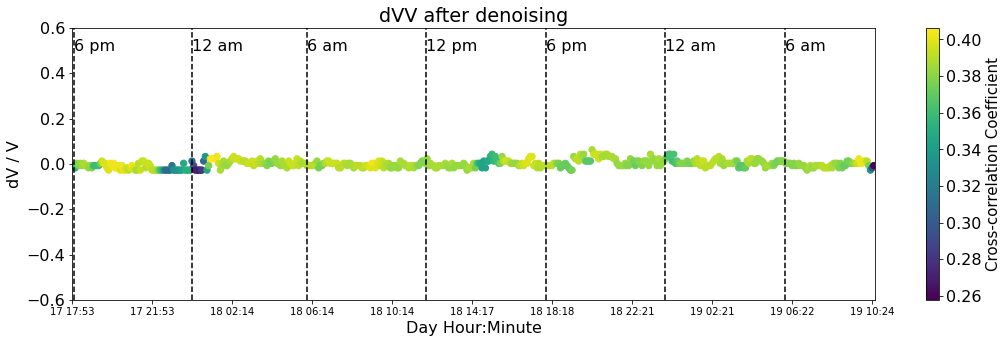

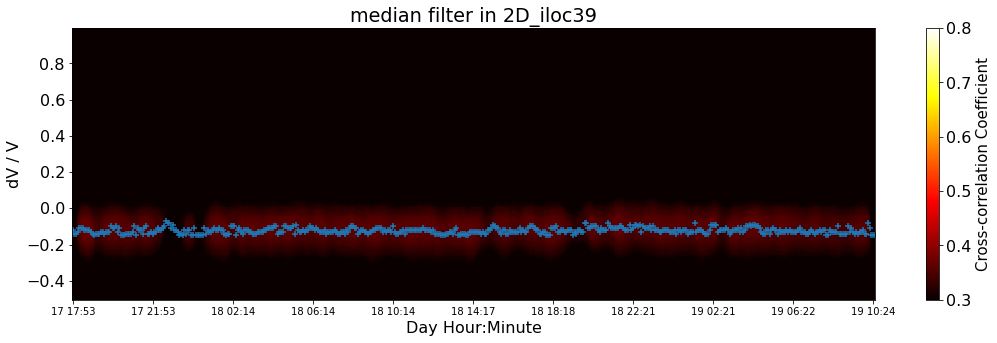

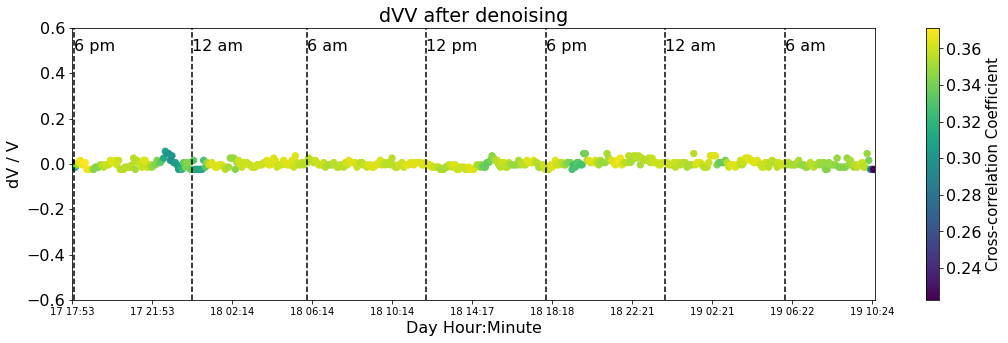

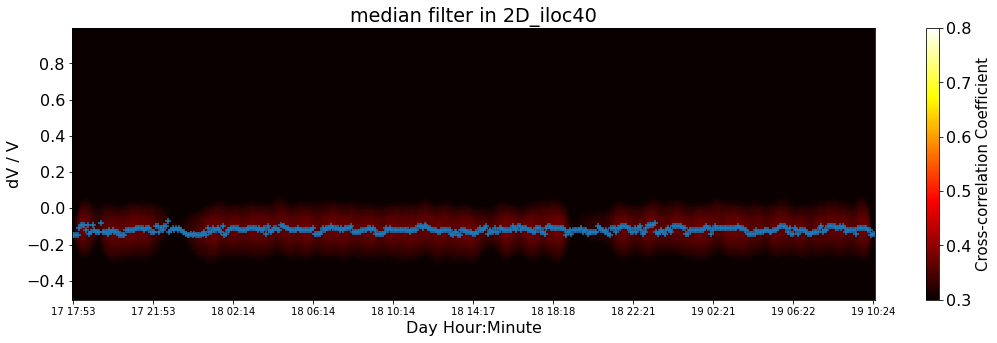

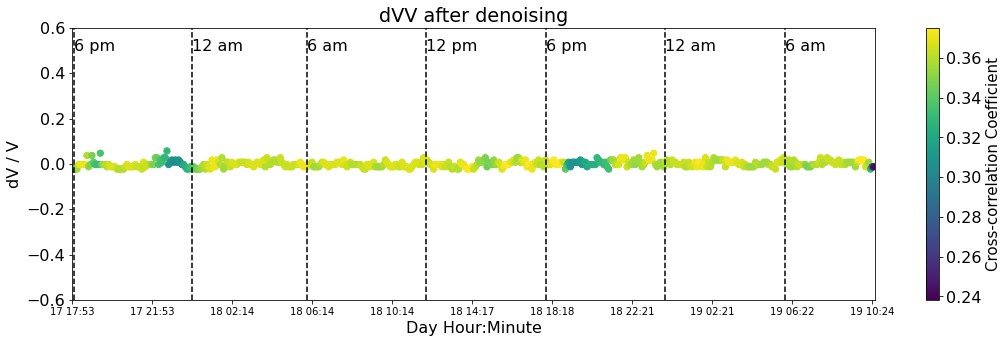

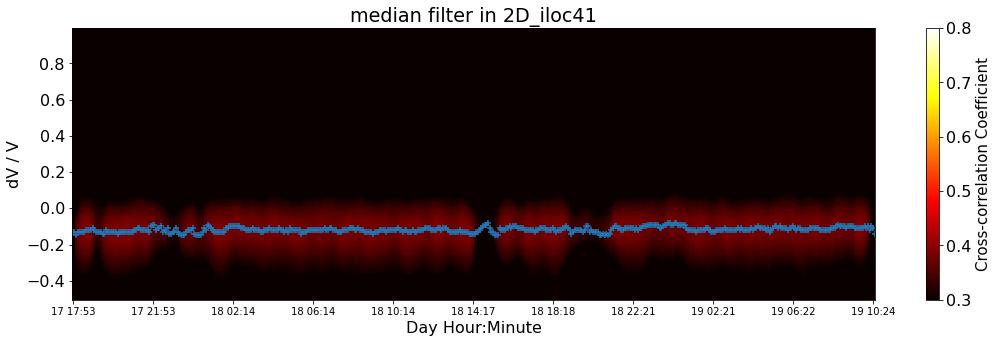

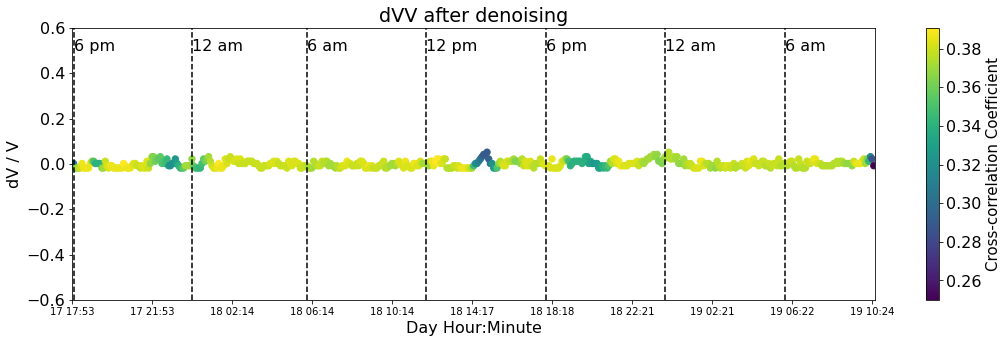

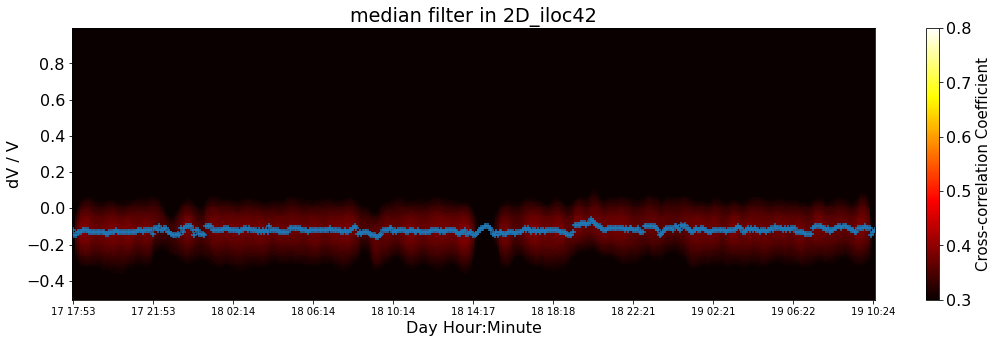

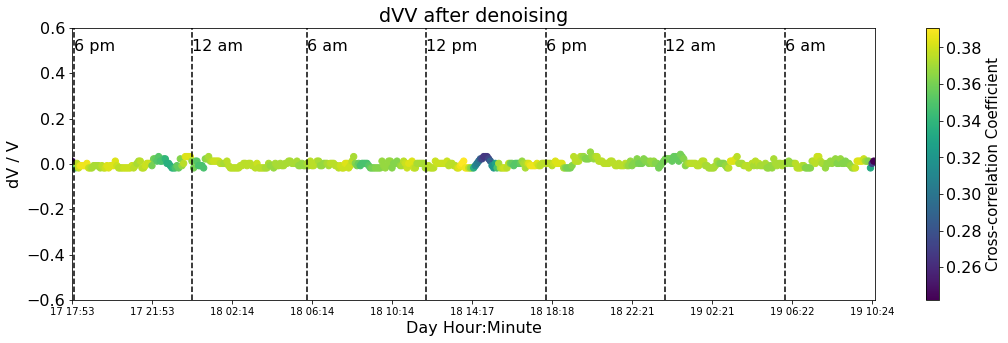

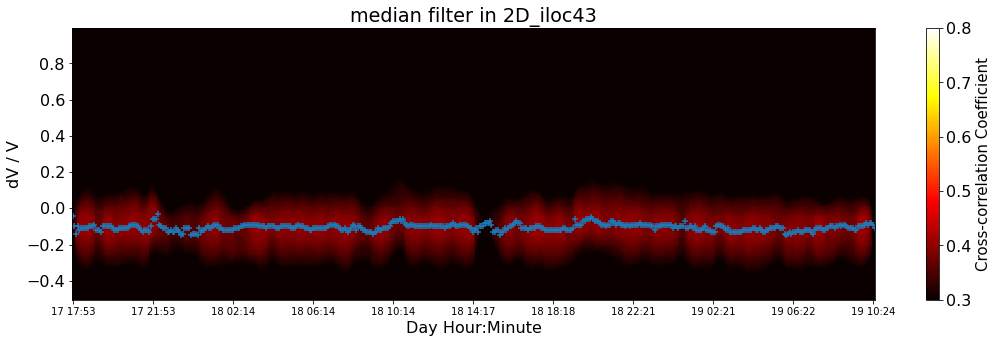

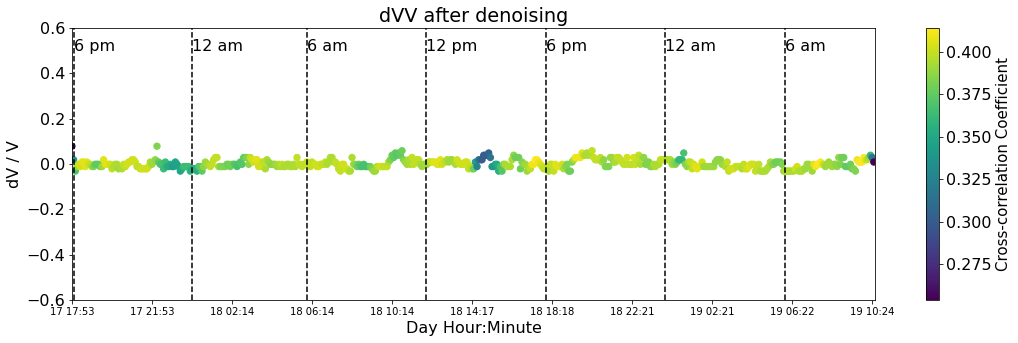

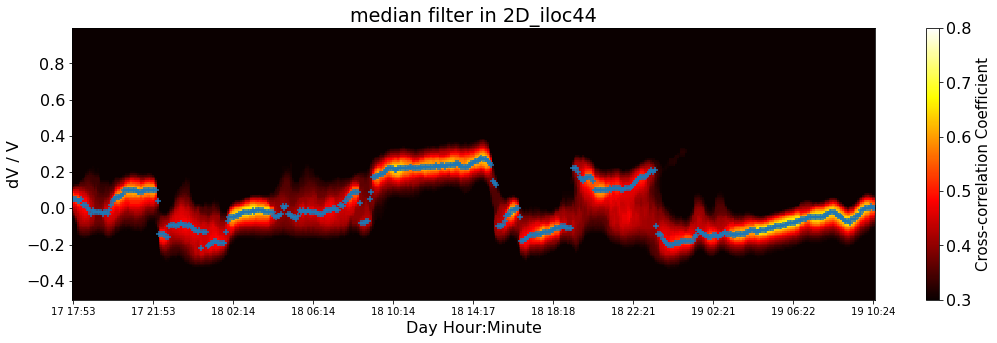

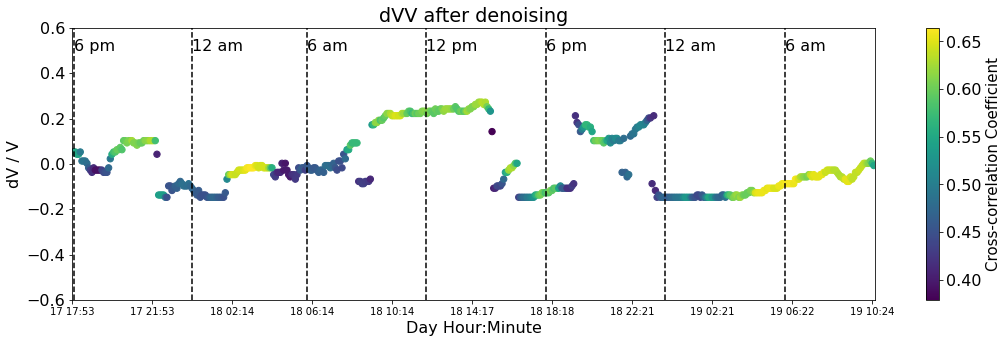

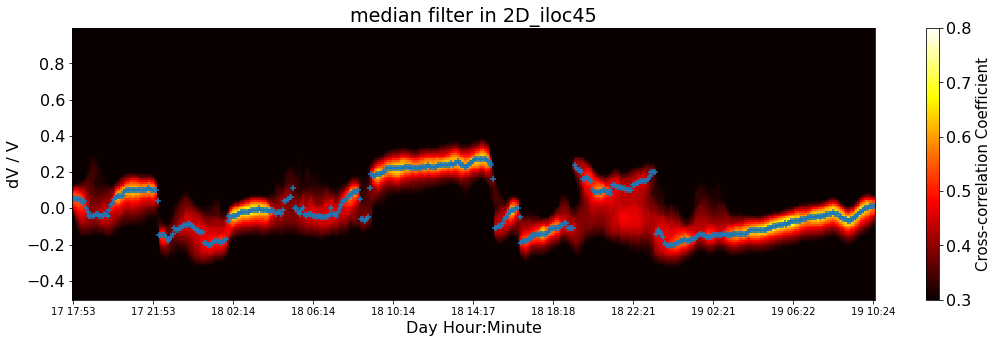

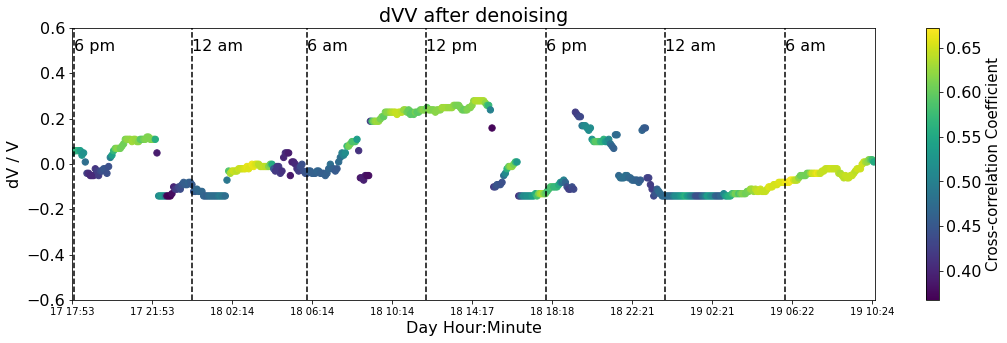

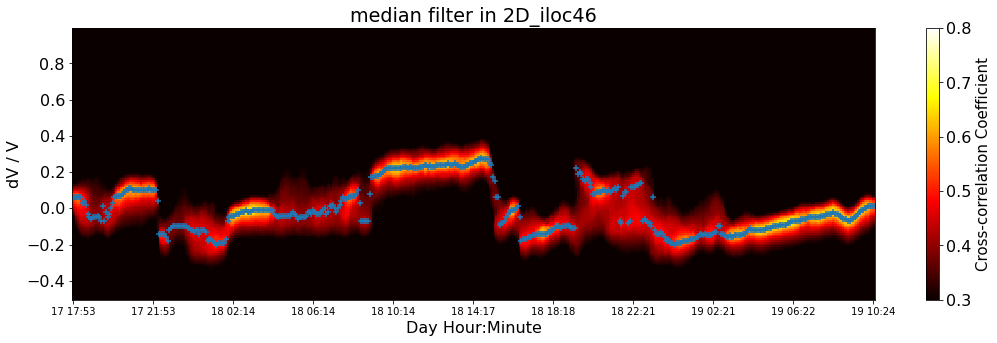

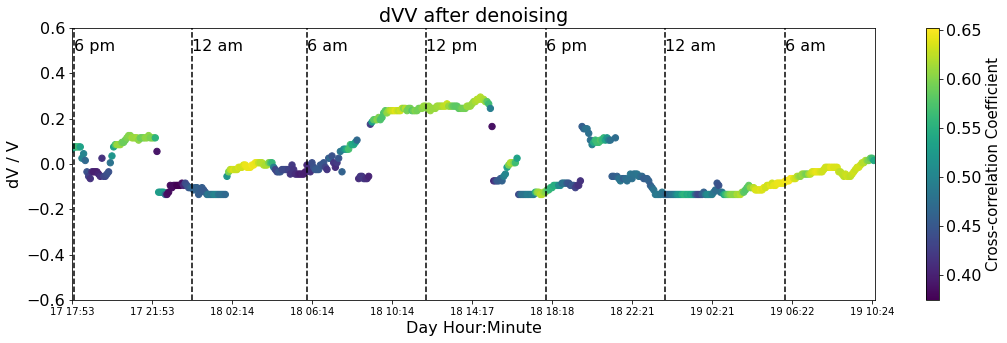

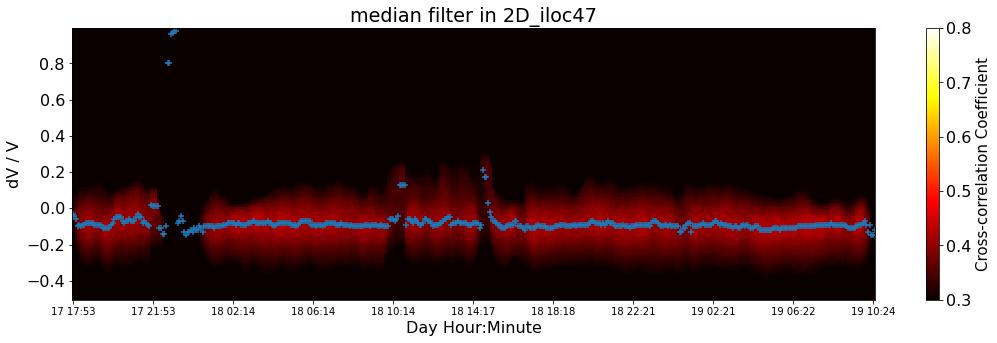

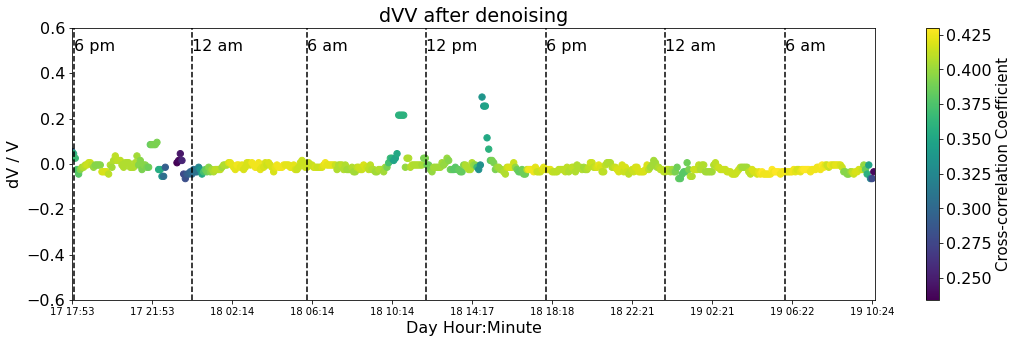

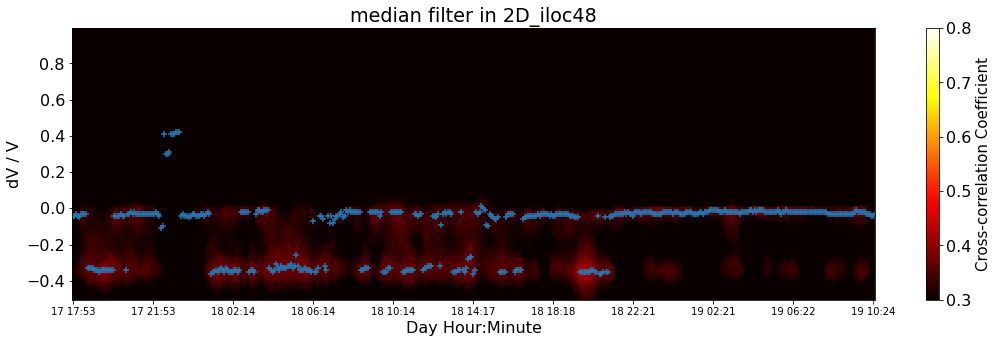

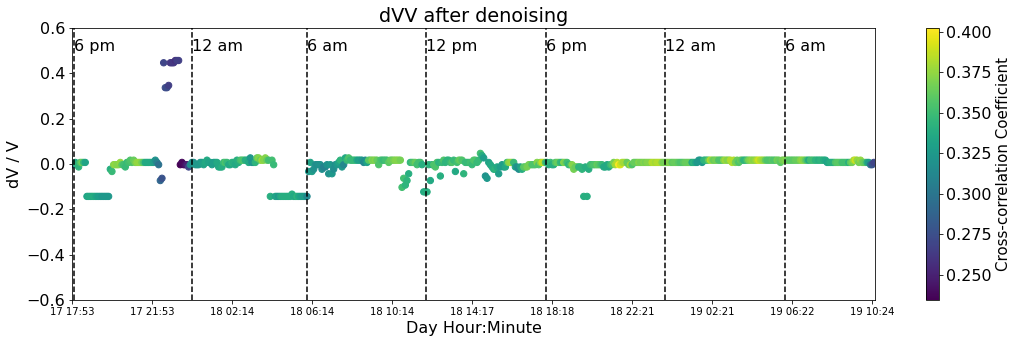

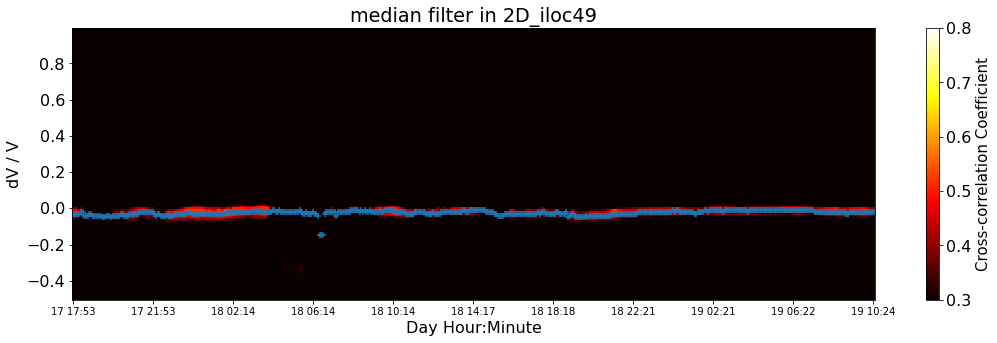

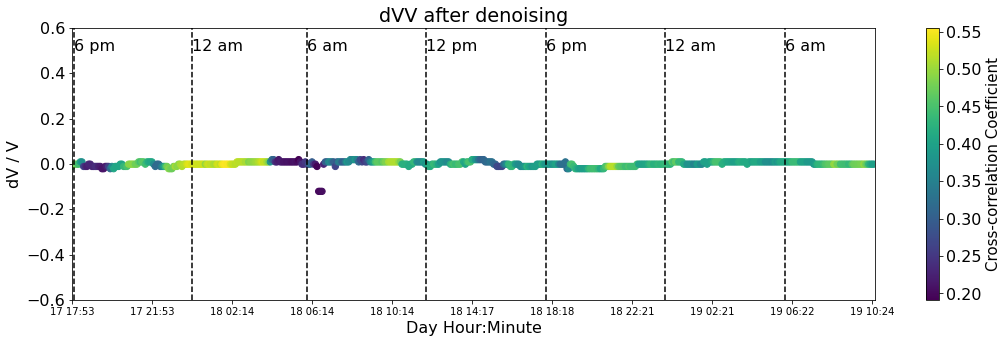

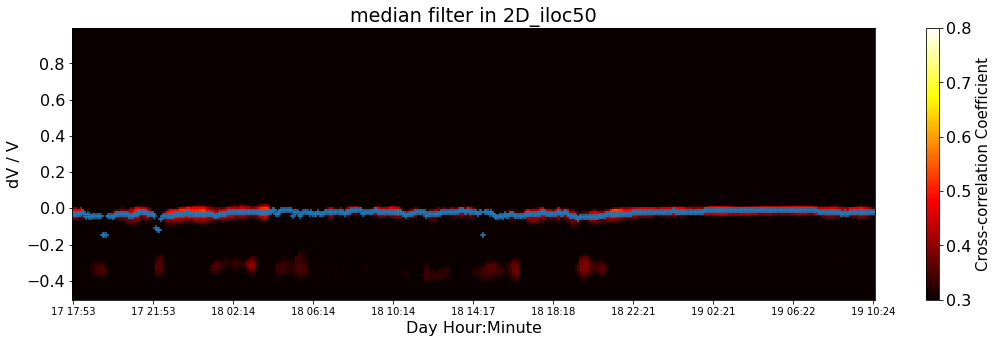

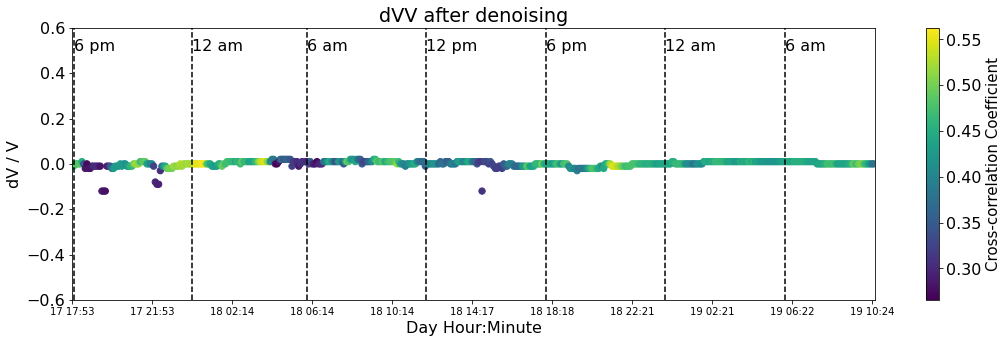

In [44]:
std_of_dvv = np.std(all_dvv, axis=1)

# Search dvv again between [-std, std] of the 1st-round dvv  
time = y[win_st:] / samp_freq

new_dvv = np.zeros((51, len(x)), dtype = np.float32)
new_cc = np.zeros((51, len(stretch_range), len(x)), dtype = np.float32)
cc_dvv = np.zeros((51, len(x)), dtype = np.float32)
peaks = np.zeros((51, len(x)),dtype=np.float32)


xax=np.arange(0, x.shape[-1], 48)
tax=acqu_time[:2410:240]

for iloc in range(51):
    data_plot=corr_all_time[iloc].T
    trunc_acf = data_plot[win_st:, :]
    trunc_stk = stack_stretch[iloc, :]/count
    strecthed_acfs = np.zeros_like(trunc_acf)
    for i in x:
        ratios, ccs = stretch_distribution(trunc_stk, trunc_acf[:,i], time, max_ratio=2)
        new_cc[iloc, :, i] = ccs 
        
    ######################
    ## Denoising
    # %% Use cone-filter
    filt_data, filtered_fk, fk2d = fk_filter_2cones(new_cc[iloc].T, w1=0.03, w2=0.005, cone1=True, cone2=False)
    image = filt_data.real.T[:,:,np.newaxis]*200
    image = image - np.nanmin(image)
    denoised_image = cv2.medianBlur(image.astype(np.uint8), 7)/256
    
    plt.figure(figsize=(18, 5))
    plt.pcolormesh(x, stretch_range-1, denoised_image, shading='auto', vmin=0.3, vmax=0.8, cmap = 'hot')
    plt.title('median filter in 2D_iloc' + str(iloc))
    plt.xticks(xax, hrax, fontsize = 10)
    bar=plt.colorbar()
    bar.set_label('Cross-correlation Coefficient', fontsize = 15)
    plt.xlabel("Day Hour:Minute", fontsize = 16)
    plt.ylabel("dV / V", fontsize = 16)
    
    #######################
    ## set bounds using 1st round dvv
    lower_ind = min(int((0.5-std_of_dvv[iloc])/0.01), 35)
#     upper_ind = int((0.5+std_of_dvv[iloc])/0.01)
    dvv_ind = np.argmax(denoised_image[lower_ind:, :], axis=0) + lower_ind
    
    for i in range(len(dvv_ind)):
        new_dvv[iloc, i]= stretch_range[dvv_ind[i]]
        peak_ind, _ = find_peaks(denoised_image[:, i], prominence=0.003, height=0.36)
        if len(peak_ind) > 0:
            peaks[iloc,i] = stretch_range[peak_ind[-1]]
        else: 
            peaks[iloc,i] = stretch_range[dvv_ind[i]]
    cc_dvv[iloc] = np.nanmax(denoised_image[lower_ind:, :], axis=0)
    #######################
    plt.scatter(x, peaks[iloc]-1, s=40, marker='+')
    
    plt.figure(figsize=(18, 5))
    plt.scatter(x, new_dvv[iloc]-np.mean(new_dvv[iloc]), cmap='viridis', c=cc_dvv[iloc], s=40, marker='o')
    plt.xticks(xax, hrax, fontsize = 10)
    plt.title('dVV after denoising')
    plt.ylim(-0.6, 0.6)
    plt.xlim(0, x.shape[-1])
    bar=plt.colorbar()
    bar.set_label('Cross-correlation Coefficient', fontsize = 15)
    plt.xlabel("Day Hour:Minute", fontsize = 16)
    plt.ylabel("dV / V", fontsize = 16)
    # Time frames
    for it in Ind6hrs:
        plt.axvline(x = it/5, color = 'k', linestyle='--')
    plt.text(Ind6hrs[0]/5, 0.5, '6 pm', color='k')
    plt.text(Ind6hrs[1]/5, 0.5, '12 am', color='k')
    plt.text(Ind6hrs[2]/5, 0.5, '6 am', color='k')
    plt.text(Ind6hrs[3]/5, 0.5, '12 pm', color='k')
    plt.text(Ind6hrs[4]/5, 0.5, '6 pm', color='k')
    plt.text(Ind6hrs[5]/5, 0.5, '12 am', color='k')
    plt.text(Ind6hrs[6]/5, 0.5, '6 am', color='k')

### Plot dvv in space

(-0.02, 0.2)

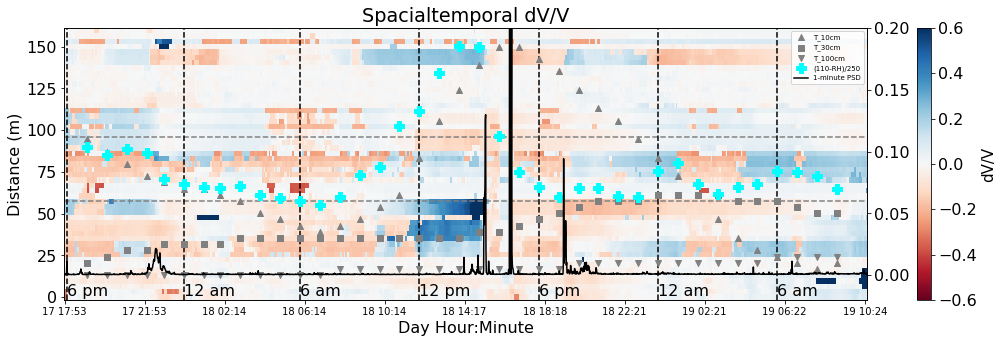

In [45]:
# improved version (find_peaks)
plt.figure(figsize=(18, 5))
plt.pcolormesh(x, np.arange(51)*dchan, peaks-np.mean(peaks, axis=1, keepdims=True), shading='auto', vmin=-0.6, vmax=0.6, cmap = 'RdBu')
plt.title('Spacialtemporal dV/V')
plt.xticks(xax, hrax, fontsize = 10)
bar=plt.colorbar()
bar.set_label('dV/V', fontsize = 15)
plt.xlabel("Day Hour:Minute", fontsize = 16)
plt.ylabel("Distance (m)", fontsize = 16)

plt.axhline(y = 18*dchan, color = 'gray', linestyle='--')
plt.axhline(y = 30*dchan, color = 'gray', linestyle='--')
for it in Ind6hrs:
    plt.axvline(x = it/5, color = 'k', linestyle='--')
plt.text(Ind6hrs[0]/5, 0.5, '6 pm', color='k')
plt.text(Ind6hrs[1]/5, 0.5, '12 am', color='k')
plt.text(Ind6hrs[2]/5, 0.5, '6 am', color='k')
plt.text(Ind6hrs[3]/5, 0.5, '12 pm', color='k')
plt.text(Ind6hrs[4]/5, 0.5, '6 pm', color='k')
plt.text(Ind6hrs[5]/5, 0.5, '12 am', color='k')
plt.text(Ind6hrs[6]/5, 0.5, '6 am', color='k')

axcopy = plt.twinx()
axcopy.scatter(np.array(hourly_index)/5, (soil_temp_10-7.5)/20, label='T_10cm', color='gray', marker='^')
axcopy.scatter(np.array(hourly_index)/5, (soil_temp_30-7.5)/20, label='T_30cm', color='gray', marker='s')
axcopy.scatter(np.array(hourly_index)/5, (soil_temp_100-7.5)/20, label='T_100cm', color='gray', marker='v')
axcopy.scatter(np.array(hourly_index)/5, (110-humidity)/250, label='(110-RH)/250', color='cyan', marker='P', s=100)
axcopy.plot(np.arange(ave_psd.shape[-1])/5, ave_psd, label='1-minute PSD', color='k')
axcopy.legend(fontsize = 7)
axcopy.set_ylim(-0.02,0.2)

(-0.02, 0.2)

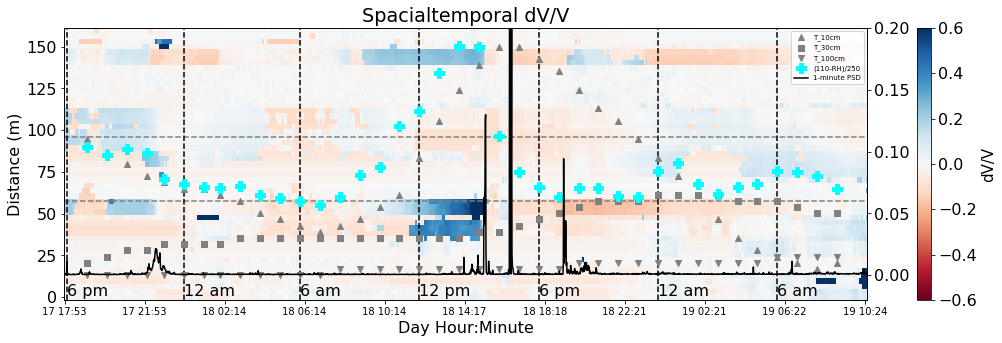

In [13]:
# old version (set lower bounds)
plt.figure(figsize=(18, 5))
plt.pcolormesh(x, np.arange(51)*dchan, new_dvv-np.mean(new_dvv, axis=1, keepdims=True), shading='auto', vmin=-0.6, vmax=0.6, cmap = 'RdBu')
plt.title('Spacialtemporal dV/V')
plt.xticks(xax, hrax, fontsize = 10)
bar=plt.colorbar()
bar.set_label('dV/V', fontsize = 15)
plt.xlabel("Day Hour:Minute", fontsize = 16)
plt.ylabel("Distance (m)", fontsize = 16)

plt.axhline(y = 18*dchan, color = 'gray', linestyle='--')
plt.axhline(y = 30*dchan, color = 'gray', linestyle='--')
for it in Ind6hrs:
    plt.axvline(x = it/5, color = 'k', linestyle='--')
plt.text(Ind6hrs[0]/5, 0.5, '6 pm', color='k')
plt.text(Ind6hrs[1]/5, 0.5, '12 am', color='k')
plt.text(Ind6hrs[2]/5, 0.5, '6 am', color='k')
plt.text(Ind6hrs[3]/5, 0.5, '12 pm', color='k')
plt.text(Ind6hrs[4]/5, 0.5, '6 pm', color='k')
plt.text(Ind6hrs[5]/5, 0.5, '12 am', color='k')
plt.text(Ind6hrs[6]/5, 0.5, '6 am', color='k')

axcopy = plt.twinx()
axcopy.scatter(np.array(hourly_index)/5, (soil_temp_10-7.5)/20, label='T_10cm', color='gray', marker='^')
axcopy.scatter(np.array(hourly_index)/5, (soil_temp_30-7.5)/20, label='T_30cm', color='gray', marker='s')
axcopy.scatter(np.array(hourly_index)/5, (soil_temp_100-7.5)/20, label='T_100cm', color='gray', marker='v')
axcopy.scatter(np.array(hourly_index)/5, (110-humidity)/250, label='(110-RH)/250', color='cyan', marker='P', s=100)
axcopy.plot(np.arange(ave_psd.shape[-1])/5, ave_psd, label='1-minute PSD', color='k')
axcopy.legend(fontsize = 7)
axcopy.set_ylim(-0.02,0.2)

In [ ]:
# with h5py.File('/fd1/QibinShi_data/England_farm/all_dvv_denoised.hdf5', 'w') as f:
#     f.create_dataset("dvv_denoised", data=new_dvv)
#     f.create_dataset("cc_denoised", data=new_cc)

### Interpolate soil measurements

In [46]:
interpx = np.arange(ave_psd.shape[0])

interp_f = interp1d(hourly_index, humidity, bounds_error=False, fill_value="extrapolate")
interp_humidity = interp_f(interpx)

interp_f = interp1d(hourly_index, soil_temp_10, bounds_error=False, fill_value="extrapolate")
interp_temp10 = interp_f(interpx)

interp_f = interp1d(np.arange(0,ave_psd.shape[0],5), new_dvv, axis=-1, bounds_error=False, fill_value="extrapolate")
interp_dvv = interp_f(interpx)

interp_f = interp1d(np.arange(0,ave_psd.shape[0],5), peaks, axis=-1, bounds_error=False, fill_value="extrapolate")
interp_peaks = interp_f(interpx)

interp_f = interp1d(np.arange(0,ave_psd.shape[0],5), cc_dvv, axis=-1, bounds_error=False, fill_value="extrapolate")
interp_cc = interp_f(interpx)

In [47]:
xax=np.arange(0, ave_psd.shape[-1], 240)
tax=acqu_time[:ave_psd.shape[-1]:240]
hrax=[dt.strftime('%d %H:%M') for dt in tax]

In [ ]:
#### plt.figure(figsize=(18, 5))

plt.pcolormesh(interpx, np.arange(51)*dchan, interp_peaks-np.mean(interp_peaks, axis=1, keepdims=True), shading='auto', vmin=-0.6, vmax=0.6, cmap = 'RdBu')
plt.title('Spacialtemporal dV/V')
plt.xticks(xax, hrax, fontsize = 10)
bar=plt.colorbar()
bar.set_label('dV/V', fontsize = 15)
plt.xlabel("Day Hour:Minute", fontsize = 16)
plt.ylabel("Distance (m)", fontsize = 16)

plt.axhline(y = 18*dchan, color = 'gray', linestyle='--')
plt.axhline(y = 30*dchan, color = 'gray', linestyle='--')
for it in Ind6hrs:
    plt.axvline(x = it, color = 'k', linestyle='--')
plt.text(Ind6hrs[0], 0.5, '6 pm', color='k')
plt.text(Ind6hrs[1], 0.5, '12 am', color='k')
plt.text(Ind6hrs[2], 0.5, '6 am', color='k')
plt.text(Ind6hrs[3], 0.5, '12 pm', color='k')
plt.text(Ind6hrs[4], 0.5, '6 pm', color='k')
plt.text(Ind6hrs[5], 0.5, '12 am', color='k')
plt.text(Ind6hrs[6], 0.5, '6 am', color='k')

axcopy = plt.twinx()
axcopy.scatter(interpx, (interp_temp10-7.5)/20, label='T_10cm', color='gray', marker='^')
axcopy.scatter(interpx, (110-interp_humidity)/250, label='(110-RH)/250', color='cyan', marker='P', s=100)
axcopy.plot(interpx, ave_psd, label='1-minute PSD', color='k')
axcopy.legend(fontsize = 7)
axcopy.set_ylim(-0.02,0.2)

In [49]:
with h5py.File('/fd1/QibinShi_data/England_farm/interp_dvv_temp_moisture.hdf5', 'w') as f:
    f.create_dataset("dvv", data=interp_dvv)
    f.create_dataset("dvv_refined", data=interp_peaks)
    f.create_dataset("cc", data=interp_cc)
    f.create_dataset("temperature", data=interp_temp10)
    f.create_dataset("moisture", data=interp_humidity)
    f.create_dataset("psd_rain", data=ave_psd)